ToDo: 


In [1]:
import sys
sys.path.append('e:\solar flares\data\\2017-09-06')


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\607442616.py:2: SyntaxWarning: invalid escape sequence '\s'
  sys.path.append('e:\solar flares\data\\2017-09-06')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import use_nessi as un
import use_nessi2 as un2
# import os
from importlib import reload

# from matplotlib import cm
# import matplotlib.cbook as cbook
# import matplotlib.colors as colors
# from scipy.interpolate import interp1d
from PIL import Image
from matplotlib import transforms



sr = solar_radius = 959.63
area_factor = 60**2/np.pi/sr**2

In [3]:
import scipy

    
def get_data(lines):
    data = un.load_for_further_analysis(lines, un.get_full_path(lines[0]))
    for line in lines:
        if "CaK" in line:
            un2.disgard_cont_point(line, data)
    
    return data 

def index_match(lines, name):
    for i, line in enumerate(lines):
        if line in name:
            return i
    raise IndexError(f'No line in lines (={lines}) matches {name}. ')
    
def ax_contr(wav, time, DFD, name, line, ax, fig, cmap='RdBu_r'):
        W, T = np.meshgrid(wav, time)
        print("scaled flare: Line", name)
        l_0 = wav[np.where(line == np.min(line))[0][0]]
        if 'He' in name:
            l_0 = 5876.4

        un2.ax_contrastplot(fig, ax, W, T, DFD, wav, line, decorations={"title":f"{latex_name(name)} Contrast profile"}, 
                            seperate_colorbar=True, vlim=None, cmap=cmap, lambda_0=l_0)

class timelim():
    def __init__(self):
        self.mins = []
        self.maxs = []
        
    def add_timestap(self, times):
        self.mins.append(np.min(times))
        self.maxs.append(np.max(times))
        
    def get_lim(self, space=0):
        x,y = (min(self.mins), max(self.maxs))
        D = y-x
        return (x - D * space, y + D * space)
        

def all_official_start_flare(name, except_time=None):
    """Returns the indices over which to average to get a good quiet pattern to calculate the contrast profile from.

    Args:
        name (string): name of the line

    Returns:
        [t0, t1]: begin and end time of the quiet flare time
    """
    if "23a" in name:
        return "09:30:00"
    elif "23" in name:
        return "16:48:00"
    elif "15b" in name:
        return "11:55:00"
    elif "24a" in name:
        return "12:27:00"
    elif "22a" in name:
        return "08:00:00"
    elif "22" in name:
        return "07:35:00"
    elif "16" in name:
        return "11:28:00"
    elif "21a" in name:
        return "15:17:00"   
    elif "21" in name:
        return "09:46:00"
    elif "9u" in name:
        return "08:57:00"
    elif "17a" in name:
        return "15:35:00"
    elif "17" in name:
        return "11:53:00"
    elif "15a" in name:
        return "10:20:00"
    elif "15" in name:
        return "15:12:00"
    elif "14a" in name:
        return "16:50:00"
    elif "14" in name:
        return "12:36:00"   
    elif "13" in name:
        return "09:11:00"
    elif "19" in name:
        return "08:41:00"
    raise NameError(f'WRONG NAME: the line {name} had no official start flare defined.')


def Full_line_ana(fig, ax, names_of_lines_list, scalefactor, T_norm={}, name_of_flare='', name_of_show_line=None, data=None, cocotime=None):
    # fig.supylabel("Elapsed Time Since Flare Onset [min]")
    # fig.supxlabel(r"Wavelength [$\rm\AA$]")
    
    TL = timelim()
    
    if data is None:
        data = get_data(names_of_lines_list)
    for i, name in enumerate(names_of_lines_list):
        wav, DFD , time, line, std = un2.contrast_FD_data(name,data, quiet_sun_subtraction=False, 
                                                          area_factor=area_factor*scalefactor, add_noise=False, theoretical=False)
        TL.add_timestap(time)
        params, voigt, res = load_voigt_data(name, wav)
        cmap = 'RdBu_r' if (data[f'True_nessi_{name}'] and 'Fe' not in name) else 'viridis'
        ax_contr(wav, time, DFD, name, line, ax[0, i], fig, cmap=cmap)
        c = area_factor*scalefactor
        ax_visualize_analysis(ax[1, i], c*res, c*voigt, wav, time, name, cmap=cmap, lambda_0=wav[np.where(line == np.min(line))[0][0]])
    lim = TL.get_lim()
    for i in range(len(names_of_lines_list)):
        ax[0, i].set_ylim(lim)
        ax[1, i].set_ylim(lim)
        
    flarename = flarename_from_title(name_of_flare)

    plot_DEW(ax[0, -1], data, names_of_lines_list, scalefactor, flarename, TL, T_norm=T_norm)
    if name_of_show_line is None:
        name_of_show_line = names_of_lines_list[0]
    wav, DFD , time, line, std = un2.contrast_FD_data(name_of_show_line, data, quiet_sun_subtraction=False, 
                                                          area_factor=area_factor*scalefactor, add_noise=False, theoretical=False)
    ax_mu_frame(ax[1, -1], name_of_show_line, cocotime=un.time_hulp(time[cocotime]+un.hulp_time(all_official_start_flare(name_of_show_line))))
    
    for i in range(len(names_of_lines_list)):
        ax[0, i].set_xlabel(r"Wavelength [$\rm\AA$]")
        ax[1, i].set_xlabel(r"Wavelength [$\rm\AA$]")
        ax[0, i].set_ylabel("Elapsed Time Since Flare Onset [min]")
        ax[1, i].set_ylabel("Elapsed Time Since Flare Onset [min]")
        ax[1, i].ticklabel_format(useOffset=False, axis='x')
        ax[0, i].ticklabel_format(useOffset=False, axis='x')
    
    in_latex_fig(name_of_flare, names_of_lines_list, scalefactor, data)
    
    # Rotate x-ticks in all subplots
    for ax in fig.get_axes():
            ax.tick_params(axis='x', which='major', rotation=-23)  # Rotate x-ticks by 45 degrees  

        
        
        
        
        
            
    
def color_for_name(name):
    colors = {'Ha':'red', 'CaK(2)':'purple', 'CaK':'violet', 'CaI':"darkred", "Fe":"orange", "Hbeta":"blue", "He":"gold"}
    for line in colors:
        if line in name:
            return colors[line]
    raise ValueError(f'The given name {name} is not linked to a color yet.')

def plot_W(ax, data, names, scalefactor, shift=False):
    under_bound=0
    for name in names:
        W, time = calculate_W(data, name, scalefactor)
        W = np.array(W)
        scale = round(np.log(max(np.max(W), -np.min(W)))/np.log(10)) if len(names)>1 else 0
        a = (np.average(W / (10**scale)) if shift else 0)
        print(a)
        ax.plot(
            time,
            W / (10**scale) - a ,
            '--',
            color=color_for_name(name),
            label=f"""{latex_name(name)}{f", x10^{str(scale)}" if scale != 0 else ''}""",
        )
        under_bound = min(np.percentile(W/10**scale, 2), under_bound)
    ax.set_title(r'Time evolution of the width $W$ with $\Delta \lambda = 4 \rm\AA$. ')
    ax.set_xlabel('Time from begin of flare [min]')
    ax.set_ylabel(r'$W$ $[\rm\AA]$')
    if under_bound<0:
        ax.set_ylim(bottom=under_bound, top=None)  # Set top to None to avoid automatic adjustment
    ax.legend()
    

def calculate_W(data, name, scalefactor=1, Dlambda=4):
    sr = 959.63
    area_factor= 60**2/np.pi/sr**2*scalefactor
    
    wav, DS, time, line, std = un2.contrast_FD_data(name, data, quiet_sun_subtraction=False, num=100,area_factor=area_factor, add_noise=False)
    
    DS -= 1 
    # wav, DFD , time, line, std = un2.difference_FD_data(name,data, quiet_sun_subtraction=False, area_factor=area_factor,
    #                                                   add_noise=False)

    line_center = wav[np.where(line == np.min(line))[0][0]]
    interval = [line_center-Dlambda, line_center+Dlambda]
    
    W = []

    for frame in range(np.shape(time)[0]):
        

        x, restx = un.restrict_intervalx2(interval, wav)
        # print(np.shape(x), np.shape(restx(DFD)), x, DFD[frame] )
        DSL2 = DS * (wav - line_center) **2

        W.append( 
                   scipy.integrate.simpson(y=restx(DSL2[frame]), x=x, dx=1.0, axis=-1, even='avg')/
                   scipy.integrate.simpson(y=restx(DS[frame]), x=x, dx=1.0, axis=-1, even='avg'))

    return W, time

offset_DEW = np.zeros(7)
scales_DEW = np.ones(7)

def get_quiet_flare_time(names):
    name = names[0]
    T = np.array(un2.most_quiet_flare_time(name))
    print(f"The normalizatie segment is {T}")
    # T0 = un.hulp_time(all_official_start_flare(name))
    return T #+ T0
    
def plot_DEW(ax, data, names, scalefactor, flarename, timelim, GOES=True, shift=False, T_norm={}):
    under_bound = 0
    upper_bound = 0
    xmin, xmax = get_quiet_flare_time(names)
    ax.axvspan(xmin, xmax, facecolor='lightgreen', alpha=1)
    for i, name in enumerate(names):
        dew, time = DEW(data, name, scalefactor)
        dew = np.array(dew)
        # scale = round(np.log(max(np.max(dew), -np.min(dew)))/np.log(10), 1) 
        ax.plot(
            time,
            (dew / np.abs(dew[0])) * scales_DEW[i] + offset_DEW[i],
            '-',
            color=color_for_name(name),
            markersize=5,
            
            # '-o',
            # color='black',
            # markerfacecolor=color_for_name(name),
            # markeredgewidth=0.5,
            # markersize=5,
            
            label=latex_name(name) # f"""{latex_name(name)}{f", x10^{str(scale)}" if scale != 0 else ''}"""
        )
        # t = T_norm[un2.element_from_name(name)]
        # print(f"Nomalization of line {name} at frame {t}.")
        # ax.plot(time[t], 
        #         ((dew / np.abs(dew[0])) * scales_DEW[i] + offset_DEW[i])[t], 
        #         'D',
        #         color='black',
        #         markerfacecolor="gray",
        #         markeredgewidth=0.5,
        #         markersize=8,
        #         )
        under_bound = min(np.min(dew/np.abs(dew[0])), under_bound)
        upper_bound = max(np.max(dew/np.abs(dew[0])), upper_bound)
        # quiet_sun = data[name][f'quiet_sun_{name}']
        
        print(name, 'Bounds:', upper_bound, under_bound)
    # ax.set_ylim(bottom=under_bound, top=upper_bound)  # Set top to None to avoid automatic adjustment
    if GOES:
        add_GOES(ax, flarename, timelim, upper_bound, under_bound)
    
    # ax.set_title(r' $\Delta EW $ with $\Delta \lambda = 0.5 \rm\AA$. ')
    ax.set_xlabel('Elapsed Time Since Flare Onset [min]')
    ax.set_ylabel(r' $\delta EW $')
    ax.legend()

def DEW(data, name, scalefactor=1, Dlambda=0.5):
    sr = 959.63
    area_factor= 60**2/np.pi/sr**2*scalefactor
    
    wav, DFD , time, line, std = un2.difference_FD_data(name,data, quiet_sun_subtraction=False, area_factor=area_factor,
                                                      add_noise=False)

    line_center = wav[np.where(line == np.min(line))[0][0]]
    print(f'line center at {line_center}')
    interval = [line_center-Dlambda, line_center+Dlambda]
    
    DEW = []

    for frame in range(np.shape(time)[0]):
        

        x, restx = un.restrict_intervalx2(interval, wav)
        # print(np.shape(x), np.shape(restx(DFD)), x, DFD[frame] )

        DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))

    return DEW, time

def gaussian(x, amp_g, cen_g, sigma_g):
    """Gaussian function."""
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    """Lorentzian function."""
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, param, offset=0):
    """Voigt profile: approximation by combining Gaussian and Lorentzian."""
    amp_v, cen_v, sigma_v, gamma_v = param
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset

def load_voigt_data(name, wav):
    fname = f"E:/solar flares/data/voigt_fitting/fit_data/voigt_data_{name}.npz"
    data =  np.load(fname) 
    params = data['arr_0']
    res = data["arr_1"]
    s = lambda x : x[0] if len(x) == 2 else x
    voigt_data= np.array([ voigt(wav, s(param)) for param in params]) 
    return params, voigt_data, res    

def latex_name(name): 
    names = {"Ha":r"$\rm{H}\alpha$", 
             "CaK":r'$\rm{Ca}~\rm{II}~\rm{K}$', 
             "CaIR":r'$\rm{Ca}~\rm{II}~8542~\rm{\AA}$', 
             "Fe6173":r'$\rm{Fe}~I~6173~\rm{\AA}$', 
             "Hbeta":r'$\rm{H}\beta$', 
             "CaK(2)":r'$\rm{Ca}~\rm{II}~\rm{H}$', 
             "He":r'$\rm{He}~I~D3$'}   # r'$\rm{He}~I~5876\rm{\AA}$'}
    el = un2.element_from_name(name)
    try:
        return names[el]
    except:
        raise ValueError(f"Name {names} is not found in the keys {names.keys()}.")

def cut_off_data(data, up_lim=None, down_lim=None):
    if up_lim is None and down_lim is None:
        up_lim = max(-np.percentile(data, 3), np.percentile(data, 97))
        down_lim = - up_lim
    elif up_lim is None:
        up_lim = np.percentile(data, 97)
    elif down_lim is None:
        down_lim = np.percentile(data, 3)
    # Apply cutoff using boolean indexing and conditional assignment
    cutoff_data = np.where(data > up_lim, up_lim, data)
    cutoff_data = np.where(data < down_lim, down_lim, cutoff_data)
    return cutoff_data

def replace_outliers(data, nsigma):
  """
  Detects outliers in a NumPy array and replaces them with the 2 sigma value in their direction.

  Args:
      data: A 1D NumPy array.

  Returns:
      A new 1D NumPy array with outliers replaced by 2 sigma values.
  """

  # Calculate mean and standard deviation
  med = np.median(data)
  std = np.std(data)

  # Define 2 sigma threshold (both upper and lower)
  lower_bound = med - nsigma * std
  upper_bound = med + nsigma * std

  data_replaced = np.where(data > lower_bound, data, lower_bound)
  data_replaced = np.where(data < upper_bound, data_replaced, upper_bound)

  return data_replaced

def ax_visualize_analysis(ax, res, voigt_data, wav, time, name, non_centered=False, cmap='RdBu_r', lambda_0=None):
    el = un2.element_from_name(name)
    print("plotting element", el, "name:", name)
    if True: #el in ["Fe6173", "CaIR", "Ha", "He", "CaK"]:
        if non_centered:
            vmax = np.percentile(res, 97)
            vmin = np.percentile(res, 3)
        else:
            vmax = max(-np.percentile(res, 10), np.percentile(res, 90))
            vmin =-vmax
            
        if "19" in name:
            print("the special flare")
            # vmin = np.percentile(res, 3)
            voigt_data= replace_outliers(voigt_data, 2)
        print(f"{vmax = }, {vmin = }")
        c = ax.imshow(np.array(res), aspect="auto", cmap=cmap, origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]),
                    vmax=vmax, vmin=vmin)

    else:
        c = ax.imshow(np.array(res), aspect="auto", cmap=cmap, origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]))
    # pcm = ax.pcolormesh(X, Y, Z, cmap='RdBu_r',vmin=-np.max(Z),  shading='auto')
    cb = fig.colorbar(c, ax=ax, extend='both')
    cb.ax.yaxis.set_offset_position('left')  
    X, Y = np.meshgrid(wav, time)
    CS = ax.contour(X, Y, voigt_data, colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10) 
    ax.set_title(f"{latex_name(name)} Voigt Fit with Residuals")

    # ax.set_xlabel(r"Wavelength [$\rm\AA$]")
    # cb.set_label(r'the residues after Voigt fit [relative intensity]')
    if lambda_0 is not None:
        if 'He' in name:
            lambda_0 = 5876.4
        ax2 = ax.secondary_xaxis('top', functions=(wav_2_doppler(lambda_0), doppler_2_wav(lambda_0)))


def wav_2_doppler(lambda_0):
    c = 299792.458 # speed of light in km/s
    return lambda wavelengths :  c * ((wavelengths-lambda_0) / lambda_0) # Correct Doppler formula

def doppler_2_wav(lambda_0):
    c = 299792.458 # speed of light in km/s
    return lambda doppler_shifts : ((doppler_shifts * lambda_0) / c) + lambda_0

    

def load_mu_frame(name):
    data = np.load(f"{un.get_full_path(name)}/line_data/contourdata{name}.npz")
    x = data["arr_1"]
    y = data["arr_2"]
    X, Y = np.meshgrid(x, y)
    ccp = data["arr_3"]
    extent = (np.min(x), np.max(x), np.min(y), np.max(y))
    rotation = data.get("arr_4", 0)
    if rotation != 0:
        print(f"\t\tUsed rotation is {rotation}.")
    MU, X, Y = square_full_mu_mesh(X, Y, angle=rotation)
    return MU, X, Y, ccp, extent, rotation

def square_full_mu_mesh(X,Y, angle, num=200):
    X = np.array([np.min(X), np.max(X)])
    Y = np.array([np.min(Y), np.max(Y)])
    X,Y = np.meshgrid(X,Y)
    X,Y = rotate_mesh_around_average(X,Y, angle)
    X = np.linspace(np.min(X), np.max(X), num)
    Y = np.linspace(np.min(Y), np.max(Y), num)
    X,Y = np.meshgrid(X,Y)
    MU = calculate_mu(X,Y)
    return MU, X, Y

def calculate_mu(x,y, radius=959.63):
    rad_dist =  (x**2 + y**2)**0.5/radius
    return np.cos(np.arcsin(rad_dist))

def rotate_mesh_around_average(xx, yy, angle):
  # Calculate the average x and y coordinates
  avg_x = np.mean(xx)
  avg_y = np.mean(yy)

  # Shift the mesh to center it around the average
  xx_centered = xx - avg_x
  yy_centered = yy - avg_y

  # Rotate the centered mesh coordinates
  xx_rot = np.cos(angle) * xx_centered -np.sin(angle) * yy_centered  + avg_x
  yy_rot = np.sin(angle) * xx_centered + np.cos(angle) * yy_centered + avg_y

  return xx_rot, yy_rot

def local_rotation(extent, rad_rot):
    mid = extent2mid(extent)
    x = np.array(mid) 
    R = np.array([[np.cos(rad_rot), -np.sin(rad_rot)], [np.sin(rad_rot), np.cos(rad_rot)]])
    y = np.dot(R, x)
    t = x-y
    return transforms.Affine2D().rotate_deg(rad_rot/np.pi*180).translate(t[0], t[1])

def extent2mid(extent):
    return ((extent[0]+extent[1])/2, (extent[2]+extent[3])/2)


def ax_mu_frame(ax, name, cocotime=None):
    MU, X, Y, ccp, extent, rotation = load_mu_frame(name)
    
    tr = local_rotation(extent, rotation)
    ax.imshow(Image.fromarray(ccp), transform=tr + ax.transData, origin='lower', extent=extent)
    CS = ax.contour(X, Y, MU)
    ax.clabel(CS, inline=True, fontsize=13)
    t = r'Contour plot $\mu$-value' if cocotime is None else f"{latex_name(name)}   {cocotime} UT"
    ax.set_title(t)
    ax.set_xlabel('X [arcsec]')
    ax.set_ylabel('Y [arcsec]')
   
def bold(str):
    return "\\textbf{"+str+"}"

def cmd_name(name):
    names = {"Ha":r"\Halpha", "CaK":'\\CaK', "CaIR":'\\CaIR', "Fe6173":'\\Fe{6173}', "Fe6302":'\\Fe{6302}', 
             "Hbeta":r'\Hbeta', "He":r'\He5832', "CaK(2)":r'\\CaH'}
    el = un2.element_from_name(name)
    try:
        return names[el]
    except:
        raise ValueError(f"Name {names} is not found in the keys {names.keys()}.")
    
def opsomming(ls_str):
    k = len(ls_str) 
    if k == 1:
        return ls_str[0]
    elif k == 2:
        return f"{ls_str[0]} and {ls_str[1]}"
    elif k>2:
        return f'{ls_str[0]}, {opsomming(ls_str[1:])}'
    else:
        raise IndentationError(' something here is not correct cannot be empty of else;..; poisjfmlksfj')
    
def no_or_pos(n):
    return f' {n}' if n > 1 else ""

def give_descr(title, lines, scalefactor, data=None):
    return f"""
    {bold(f'The full {title}:')} NESSI calculated full disk profiles 
    for $\sim {round(1/scalefactor * 100)}$\\% flare capture. {bold(f'Upper left{no_or_pos(len(lines))}:')} 
    Contrastprofiles to the quiet sun for the lines {opsomming([cmd_name(line) for line in lines])}.
    {bold(f'Lower left{no_or_pos(len(lines))}:')} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. {remark_colormap(lines, data)}
    {bold('upper right:')} Differential Equivalent Width of the available lines as a function of time. 
    {bold('Lower right:')} A cocoplot of the FOV in the {cmd_name(lines[0])} line overlayed with contour 
    lines of the $\mu$-value. 
    """
def bracket(str):
    return "{" + str + "}"

def remark_colormap(lines, data):
    Special_lines = []
    for line in lines:
        if not data[f'True_nessi_{line}']:
            Special_lines.append(line)
    if len(Special_lines)==0:
        return ""
    else:
        s =  f'''NESSI clv profiles where not available for {opsomming([cmd_name(line) for line in Special_lines])}. \
            The quiet sun profiles are used as FOV and an Atlas is used for saas profile.\
                For clarity these lines are collered differntly.'''
        return s

def in_latex_fig(title, lines, scalefactor, data=None):
    env = f'''
    \\begin{ bracket('figure*')}
        \centering
        \includegraphics[width={ (len(lines) + 1) / 4}\linewidth]{bracket(f'Full_analysis_plots/{title.replace(" ", "_")}.pdf')}
        \caption{bracket(give_descr(title, lines, scalefactor, data)) }
        \label{bracket(f'fig:{title[12:16]}')}
    \end{bracket('figure*')}
    '''
    print(env)

Xtra_N = 1
Scale_GOES = 1
def add_GOES(ax, flarename, timelim, upper_bound, under_bound):
    T, G, duration = get_GOES(flarename)
    timelim.add_timestap([0, duration])
    x,y = timelim.get_lim(space=0.03)
    i = np.where(T >= x)[0][0]
    j = np.where(T <= y)[0][-1]
    T = T[i:j]
    G = G[i:j]
    N = max((len(G) * Xtra_N)//500, 1)
    G = np.convolve(G, np.ones(N)/N, mode='valid')
    T = np.convolve(T, np.ones(N)/N, mode='valid')

    G /= np.nanmax(G)
    G *= Scale_GOES
    
    top =  np.nanmax(G) #np.percentile(G, 99)#max( , -np.percentile(G, 10))
    bottom =np.nanpercentile(G, 3)
    ax.plot(T, G, '--', label='GOES', alpha=1, linewidth=2, color='black')
    print("GOES:", top, bottom, np.nanpercentile(G, 99))
    ax.set_xlim(timelim.get_lim(space=0.03))
    # ax.set_ylim(min(under_bound,bottom), max(upper_bound,top))
    return duration

import matplotlib.pyplot as plt
from sunpy.timeseries import TimeSeries
from sunpy.net import Fido, attrs as a
import numpy as np

def download_GOES_data(begin, end, name):
        
    # Query GOES X-ray data using Fido
    results = Fido.search(a.Time(begin, end), a.Instrument("XRS"))

    # Download the data
    files = Fido.fetch(results)

    # Ensure we handle multiple files correctly
    goes_combined = TimeSeries(files, concatenate=True)  # Concatenate multiple files

    # Extract time and X-ray flux data
    time = goes_combined.to_dataframe().index  # Time index
    xrs_long = goes_combined.to_dataframe()['xrsb']  # Long channel: 0.1-0.8 nm

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.semilogy(time, xrs_long, label="GOES 0.1-0.8 nm (XRS-B)", linewidth=1)

    # Customize the plot
    plt.title(f"GOES X-ray Flux flare {name} ({begin} to {end})")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Flux (W/m²)")
    #plt.yscale("log")  # X-ray flux is typically shown on a log scale
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    np.savez(f'data/GOES_{name}.npz', time=time, xrs_long=xrs_long)


def get_GOES(flare, plot=False):
    try:
        A = np.load(f"E:\solar flares\data\\full_analysis\data\GOES_{flare}.npz")
    except FileNotFoundError as e:
        l = info_flare(flare)
        begin =  f'{l[0]} {l[1]}'
        end = f'{l[0]} {l[3]}'
        print(begin, end)
        download_GOES_data(begin, end, flare)
        A = np.load(f"E:\solar flares\data\\full_analysis\data\GOES_{flare}.npz")
    print(A)
    print(A["time"])
    print(A["xrs_long"])
    T = np.array([un.hulp_time(str(t)[11:19]) for t in A["time"][1:]]) - un.hulp_time(info_flare(flare)[1])
    duration = un.hulp_time(info_flare(flare)[3])-un.hulp_time(info_flare(flare)[1])
    
    if plot:
        plt.plot(T, A["xrs_long"])
        plt.xlim(0, duration  )
        
    return T, A["xrs_long"][1:], duration

flaredata = {'X9.3':['2017-09-06', '11:53', '12:02', '12:10', '17'], 
            'X8.2':['2017-09-10', '15:35', '16:06', '16:31', '17a'],
            'X2.2':['2017-09-06', '08:57', '09:10', '09:17', '17_9u'], 
            'X1.5':['2014-06-10', '12:36', '12:52', '13:03', '14'], 
            'X1.0':['2021-10-28', '15:17', '15:23', '15:40', '21a'],
            'M3.0':['2022-05-20', '07:35', '07:45', '07:49', '22'], 
            'M2.5':['2023-06-09', '16:48', '17:11', '17:34', '23'], 
            'M1.9':['2015-09-27', '10:20', '10:40', '10:46', '15a'], 
            'M1.8':['2024-09-11', '12:27', '12:36', '12:47', '24a'], 
            'M1.1':['2014-09-06', '16:50', '17:09', '17:22', '14a'], 
            'C8.4':['2016-05-14', '11:28', '11:34', '11:37', '16'], 
            'C5.6':['2015-06-24', '15:12', '15:29', '15:40', '15'], 
            'C4.1':['2011-08-06', '08:37', '08:47', '08:51', '11'],             
            'C3.6':['2015-05-05', '11:55', '11:58', '12:00', '15b'], 
            'C2.4':['2022-06-26', '08:00', '08:12',	'08:20', '23a'], 
            'C2.2':['2023-06-18', '09:31', '09:37', '10:09', '23a'], 
            'C2.0':['2019-05-06', '08:41', '08:47', '08:51', '19'], 
            'C1.5':['2013-06-30', '09:11', '09:18', '09:27', '13'], 
            'C1.2':['2021-05-26', '09:46', '09:55', '10:00', '21']
    }
def flarename_from_title(title):
    for k in flaredata.keys():
        if k in title:
            return k
    raise ValueError(f'the title {title} does not contain the flarename! \nNot in the keys {flaredata.keys()}')
    
def info_flare(flare):
    return flaredata[flare]


<>:508: SyntaxWarning: invalid escape sequence '\s'
<>:508: SyntaxWarning: invalid escape sequence '\m'
<>:533: SyntaxWarning: invalid escape sequence '\c'
<>:533: SyntaxWarning: invalid escape sequence '\l'
<>:533: SyntaxWarning: invalid escape sequence '\c'
<>:533: SyntaxWarning: invalid escape sequence '\l'
<>:533: SyntaxWarning: invalid escape sequence '\e'
<>:599: SyntaxWarning: invalid escape sequence '\s'
<>:606: SyntaxWarning: invalid escape sequence '\s'
<>:508: SyntaxWarning: invalid escape sequence '\s'
<>:508: SyntaxWarning: invalid escape sequence '\m'
<>:533: SyntaxWarning: invalid escape sequence '\c'
<>:533: SyntaxWarning: invalid escape sequence '\l'
<>:533: SyntaxWarning: invalid escape sequence '\c'
<>:533: SyntaxWarning: invalid escape sequence '\l'
<>:533: SyntaxWarning: invalid escape sequence '\e'
<>:599: SyntaxWarning: invalid escape sequence '\s'
<>:606: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2379255630

# 2022 a C2.4 Flare

<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\4202487454.py:30: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\4202487454.py:30: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR22a
Centerd contrast plot vmin=0.9999156085218526, vmax=1.0000843914781474.
plotting element CaIR name: CaIR22a
vmax = 1.1019896321286935e-07, vmin = -1.1019896321286935e-07
scaled flare: Line Ha22a
Centerd contrast plot vmin=0.99981829905107, vmax=1.00018170094893.
plotting element Ha name: Ha22a
vmax = 1.6521661744035766e-07, vmin = -1.6521661744035766e-07
The normalizatie segment is [47 57]
line center at 8542.1033342129
CaIR22a Bounds: 1.5508070055299419 0
line center at 6562.795538134421
Ha22a Bounds: 2.1949914215703346 0
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_C2.4.npz' with keys: time, xrs_long
['2022-06-25T23:59:59.707810000' '2022-06-26T00:00:00.000000000'
 '2022-06-26T00:00:00.000000000' ... '2022-06-26T23:59:58.100691000'
 '2022-06-26T23:59:58.956447000' '2022-06-26T23:59:59.100681000']
[1.0027977e-06 1.0362487e-06 1.0158235e-06 ... 4.8380571e-07 3.8787758e-07
 4.8658245e-07]
GOES: 1.0 0.14762756746892622 0.9923807359264348

    \beg

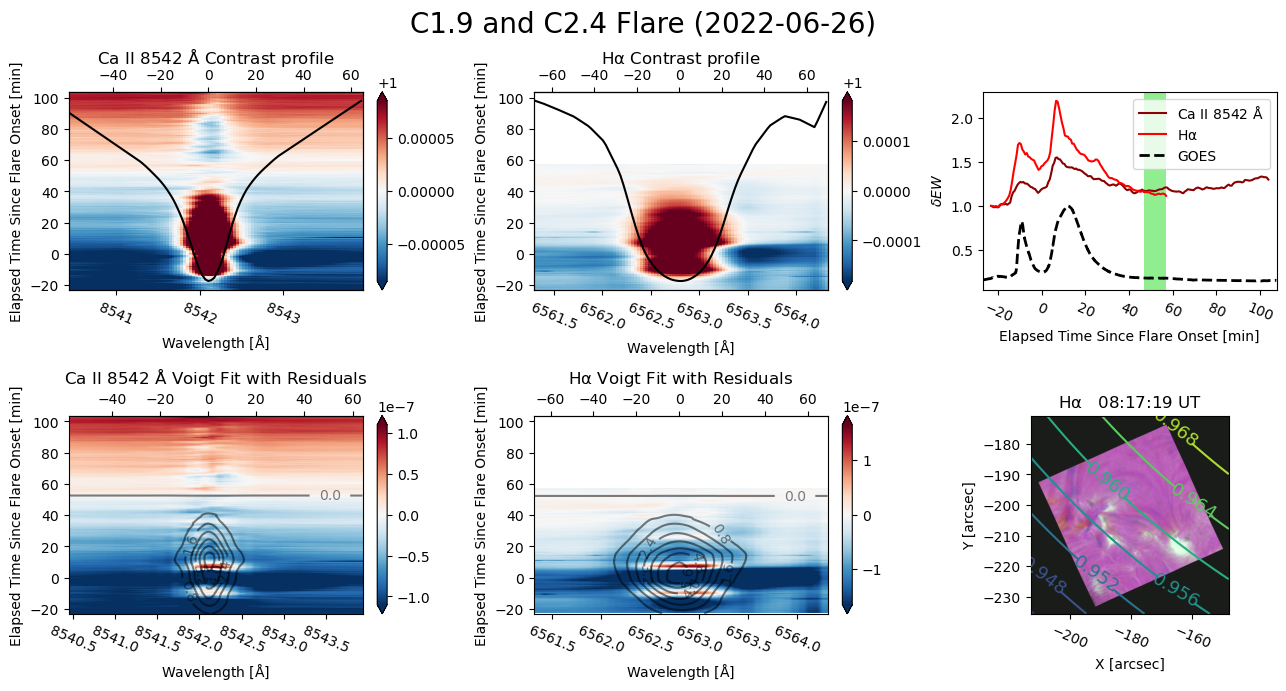

In [5]:
reload(un)
reload(un2)
# lines
lines = ["CaIR22a", "Ha22a"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = 3
title = "C1.9 and C2.4 Flare (2022-06-26)"

# make figure
t =0.85
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)


fig.suptitle(title, fontsize=20)

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot


scalefactor = 1/0.9
offset_DEW = [0,0]
norm = {"CaIR":99, "Fe6173":99, "CaK":0, "Halpha":0, "Hbeta":0 }
cocotime = 60
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Ha22a")
# ax[0,-1].set_ylim(-0.892439259639127, 1.3)
offset_DEW = np.zeros(7)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2024 a M1.8 Flare



<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2774798890.py:30: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2774798890.py:30: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR24a
Centerd contrast plot vmin=0.9999376813608112, vmax=1.0000623186391888.
plotting element CaIR name: CaIR24a
vmax = 4.2808262751897164e-08, vmin = -4.2808262751897164e-08
The normalizatie segment is [45 55]
line center at 8542.133211287966
CaIR24a Bounds: 1.3674794704462205 0
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_M1.8.npz' with keys: time, xrs_long
['2024-09-10T23:59:59.851866000' '2024-09-11T00:00:00.000000000'
 '2024-09-11T00:00:00.000000000' ... '2024-09-11T23:59:58.185747000'
 '2024-09-11T23:59:59.092471000' '2024-09-11T23:59:59.185744000']
[5.4743714e-06 5.2609889e-06 5.3001945e-06 ... 1.6412316e-05 1.6613449e-05
 1.6466225e-05]
GOES: 1.0 0.18849618106431107 0.9955752623279075

    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/M1.8_Flare_(2024-09-11).pdf}
        \caption{
    \textbf{The full M1.8 Flare (2024-09-11):} NESSI calculated full disk profiles 
    for $\sim 80$\% flare

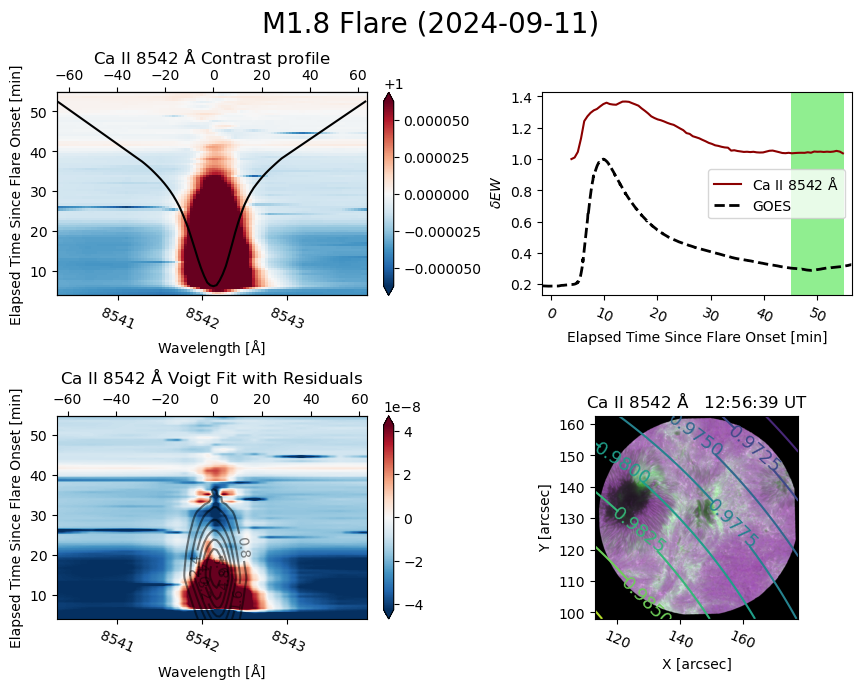

In [6]:
reload(un)
reload(un2)
# lines
lines = ["CaIR24a"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = 2
title = "M1.8 Flare (2024-09-11)"

# make figure
t = 0.85
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)


fig.suptitle(title, fontsize=20)

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot


scalefactor = 1/0.8
offset_DEW = [0,0]
norm = {"CaIR":99, "Fe6173":99, "CaK":0, "Halpha":0, "Hbeta":0 }
cocotime = 43
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="CaIR24a")
# ax[0,-1].set_ylim(-0.892439259639127, 1.3)
offset_DEW = np.zeros(7)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2021 a flare X1.0 

<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2178935733.py:30: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2178935733.py:30: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR21a
Centerd contrast plot vmin=0.9966889741981149, vmax=1.0033110258018851.
plotting element CaIR name: CaIR21a
vmax = 3.67589814791997e-07, vmin = -3.67589814791997e-07
scaled flare: Line Fe21a
Assuming that Fe21a is spectral line Fe6173.
Centerd contrast plot vmin=0.9998874123432404, vmax=1.0001125876567596.
Assuming that Fe21a is spectral line Fe6173.
plotting element Fe6173 name: Fe21a
vmax = 1.2908536771746992e-07, vmin = -1.2908536771746992e-07
Assuming that Fe21a is spectral line Fe6173.
The normalizatie segment is [45 52]
line center at 8542.113682332056
CaIR21a Bounds: 1.0489830116868897 0
line center at 6173.321421877549
Assuming that Fe21a is spectral line Fe6173.
Fe21a Bounds: 1.0489830116868897 -1.1769439488934
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_X1.0.npz' with keys: time, xrs_long
['2021-10-28T00:00:00.000000000' '2021-10-28T00:00:00.000000000'
 '2021-10-28T00:00:00.207231000' ... '2021-10-28T23:59:58.461629000'
 '2021-10-28T2

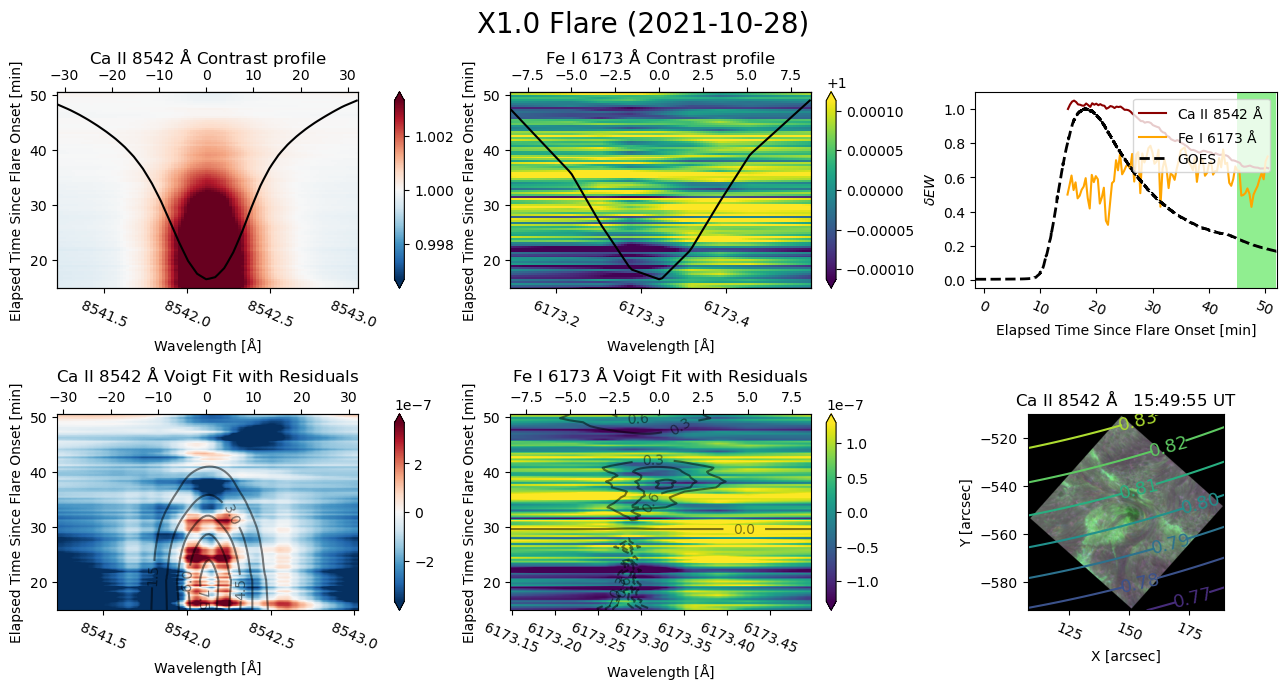

In [7]:
reload(un)
reload(un2)
# lines
lines = ["CaIR21a", "Fe21a"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = 3
title = "X1.0 Flare (2021-10-28)"

# make figure
t = 0.85
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)


fig.suptitle(title, fontsize=20)

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot


scalefactor = 1/0.1
offset_DEW = [0, 1.5]
norm = {"CaIR":99, "Fe6173":99, "CaK":0, "Halpha":0, "Hbeta":0 }
cocotime = 50
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="CaIR21a")
# ax[0,-1].set_ylim(-0.892439259639127, 1.3)
offset_DEW = np.zeros(7)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2023a flare

<string>:42: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<string>:42: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3063055351.py:42: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3063055351.py:42: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR23a
Centerd contrast plot vmin=0.9999899587180321, vmax=1.000010041281968.
plotting element CaIR name: CaIR23a
vmax = 1.119454382896976e-08, vmin = -1.119454382896976e-08
scaled flare: Line Ha23a
Centerd contrast plot vmin=0.9999797920759148, vmax=1.0000202079240852.
plotting element Ha name: Ha23a
vmax = 2.2398155320205334e-08, vmin = -2.2398155320205334e-08
scaled flare: Line He23a
Centerd contrast plot vmin=0.9999716734155644, vmax=1.0000283265844356.
plotting element He name: He23a
vmax = 1.4342045349944295e-08, vmin = -1.4342045349944295e-08
scaled flare: Line Hbeta23a
Centerd contrast plot vmin=0.9999683441166485, vmax=1.0000316558833515.
plotting element Hbeta name: Hbeta23a
vmax = 2.5341719987645233e-08, vmin = -2.5341719987645233e-08
scaled flare: Line CaK(2)23a
Centerd contrast plot vmin=0.9999273168879341, vmax=1.0000726831120659.
plotting element CaK(2) name: CaK(2)23a
vmax = 4.101492252493338e-08, vmin = -4.101492252493338e-08
The normalizatie segmen

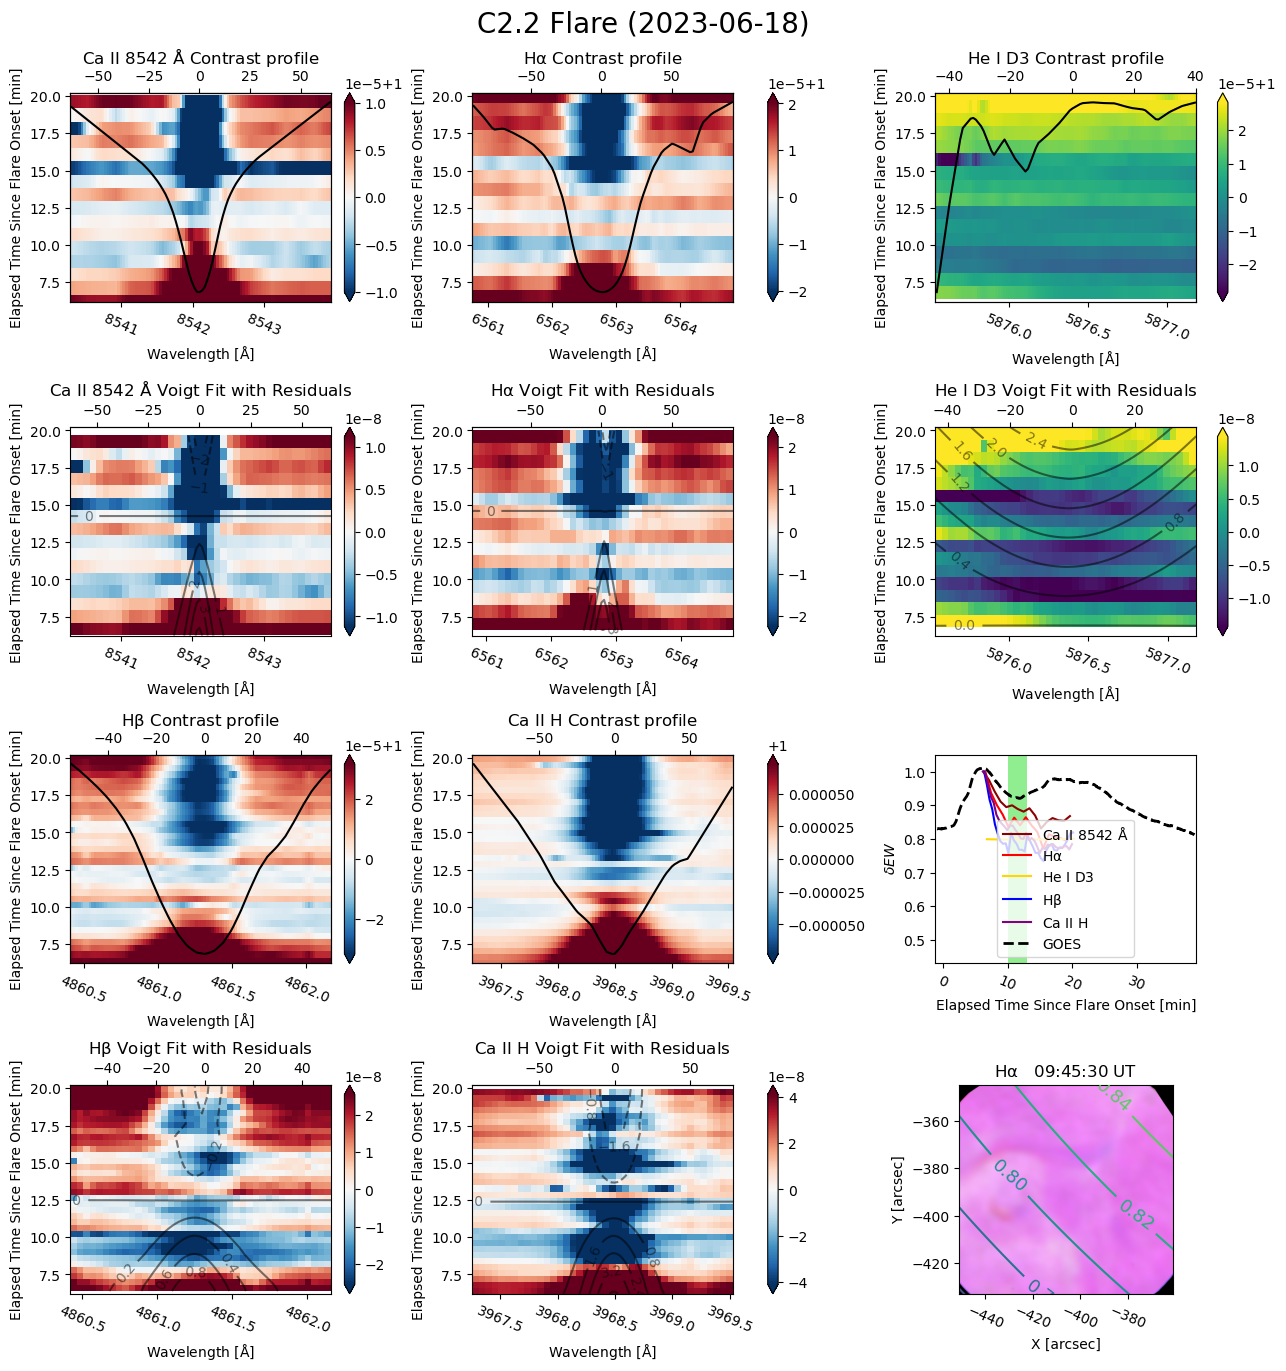

In [8]:
reload(un)
reload(un2)
# lines
lines = [ "CaIR23a", "Ha23a","He23a", "Hbeta23a", "CaK(2)23a"]
# rows: the different flares
rows = 4
# collumns: the differnt lines + DEW
cols = 3
title = "C2.2 Flare (2023-06-18)"

# make figure
t = 0.85
fig, ax2 = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
ax = np.array([
    [*ax2[0], *ax2[2]],
    [*ax2[1], *ax2[3]]
])


fig.suptitle(title, fontsize=20)


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot
offset_DEW = [0,0,0.8,0,0]
scales_DEW = [1,1,0.001,1,1]
scalefactor = 1/1
Scale_GOES = 1.01
Xtra_N = 7

norm = {"CaIR":0, "CaK(2)":0, "Fe6173":0, "CaK":0, "Ha":0, "Hbeta":0, "He":0 }
cocotime = 10
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line= "Ha23a")
ax[0,-1].set_ylim( 0.43, 1.05)
offset_DEW = np.zeros(7)
scales_DEW = np.ones(7)
ax[1, -1].set_xlim((-451,-361))
ax[1, -1].set_ylim((-433,-345))
Scale_GOES = 1
Xtra_N=1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2023 flare

<string>:37: SyntaxWarning: invalid escape sequence '\{'
<>:37: SyntaxWarning: invalid escape sequence '\{'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<string>:37: SyntaxWarning: invalid escape sequence '\{'
<>:37: SyntaxWarning: invalid escape sequence '\{'
<>:37: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1234712700.py:37: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1234712700.py:37: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


[[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >]] [[<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: >]]
scaled flare: Line CaIR23
Centerd contrast plot vmin=0.9997915100518424, vmax=1.0002084899481576.
plotting element CaIR name: CaIR23
vmax = 3.890910305989537e-08, vmin = -3.890910305989537e-08
scaled flare: Line Ha23
Centerd contrast plot vmin=0.9996455510319264, vmax=1.0003544489680736.
plotting element Ha name: Ha23
vmax = 1.1554738409680889e-07, vmin = -1.1554738409680889e-07
scaled flare: Line He23
Centerd contrast plot vmin=0.99996534904807, vmax=1.00003465095193.
plotting element He name: He23
vmax = 4.264687185226798e-08, vmin = -4.264687185226798e-08
scaled flare: Line Hbeta23
Centerd contrast plot vmin=0.9991463780001044, vmax=1.0008536219998956.
plotting element Hbeta name: Hbeta23
vmax = 1.2216551552611874e-07, vmin = -1.2216551552611874e-07
s

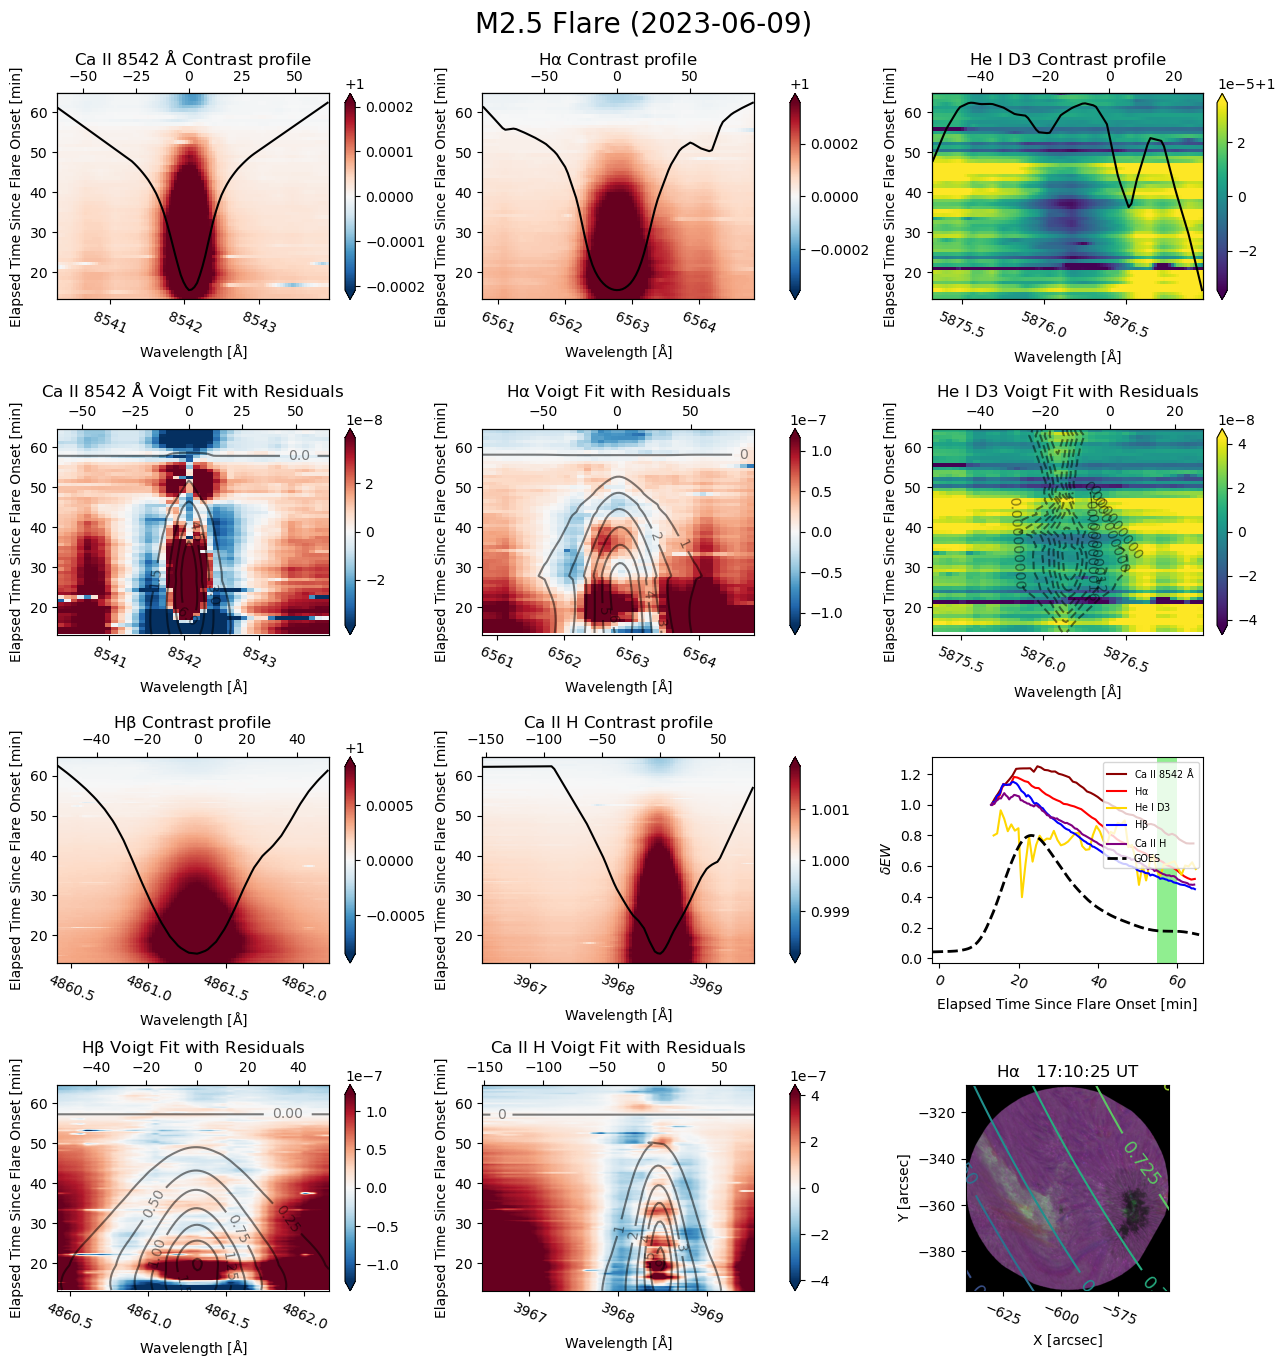

In [9]:
reload(un)
reload(un2)
# lines
lines = ["CaIR23","Ha23","He23", "Hbeta23", "CaK(2)23"]
# rows: the different flares
rows = 4
# collumns: the differnt lines + DEW
cols = 3
title = "M2.5 Flare (2023-06-09)"

# make figure
t = 0.85
fig, ax2 = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
ax = np.array([
    [*ax2[0], *ax2[2]],
    [*ax2[1], *ax2[3]]
])
print(ax, ax2)
fig.suptitle(title, fontsize=20)



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot
offset_DEW = [0,0,1.8,0,0]
scalefactor = 1/0.40
Scale_GOES = 0.8
norm = {"CaIR":0, "CaK(2)":0, "Fe6173":0, "CaK":0, "Ha":0, "Hbeta":0, "He":0 }
cocotime = 10
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Ha23")
offset_DEW = np.zeros(7)
Scale_GOES = 1
ax[0,-1].legend(fontsize = 'x-small')
ax[1, -1].set_xlim((-641,-553))
ax[1, -1].set_ylim((-397,-308))

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


# 2022 flare

<string>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<string>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1306099554.py:29: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1306099554.py:29: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR22
Centerd contrast plot vmin=0.9999119683236117, vmax=1.0000880316763883.
plotting element CaIR name: CaIR22
vmax = 3.037997008121357e-08, vmin = -3.037997008121357e-08
The normalizatie segment is [55 65]
line center at 8542.133211287966
CaIR22 Bounds: 1.0625995463224644 0
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_M3.0.npz' with keys: time, xrs_long
['2022-05-19T23:59:59.500089000' '2022-05-20T00:00:00.000000000'
 '2022-05-20T00:00:00.000000000' ... '2022-05-20T23:59:57.819855000'
 '2022-05-20T23:59:58.749083000' '2022-05-20T23:59:58.819842000']
[1.4940093e-06 1.5243392e-06 1.4843832e-06 ... 1.8102800e-06 1.7281585e-06
 1.8019497e-06]
GOES: 0.9 0.03776134632792558 0.8482576892888601

    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/M3.0_Flare_(2022-05-20).pdf}
        \caption{
    \textbf{The full M3.0 Flare (2022-05-20):} NESSI calculated full disk profiles 
    for $\sim 90$\% flare capt

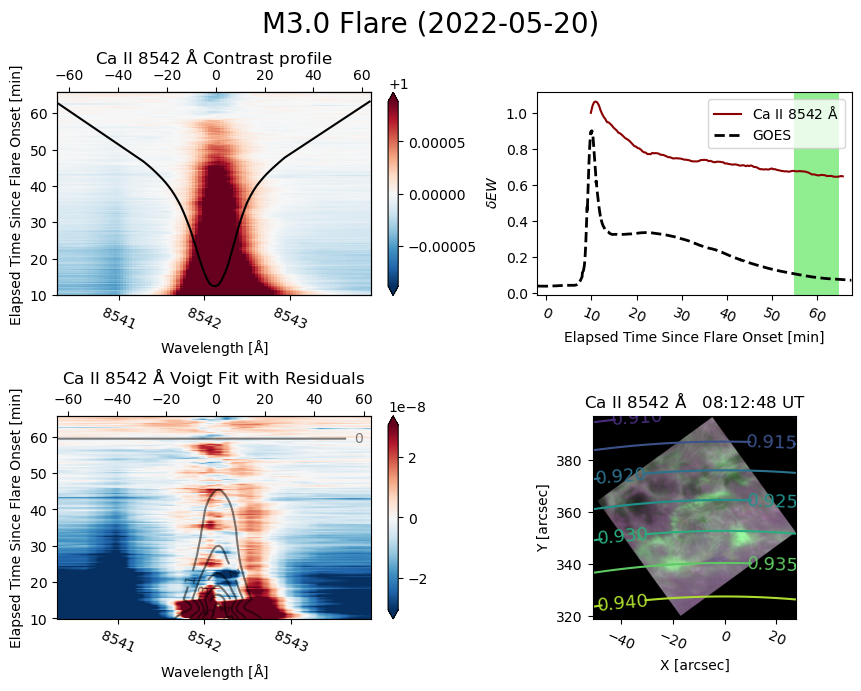

In [10]:
reload(un)
reload(un2)
# lines
lines = ["CaIR22"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "M3.0 Flare (2022-05-20)"

# make figure
t = 0.85
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)




# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot

scalefactor = 1/0.9
Scale_GOES = 0.9
norm = {"CaIR":156, "CaK(2)":28, "Fe6173":99, "CaK":0, "Ha":9, "Hbeta":62, "He":29 }
cocotime = 157//2
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime)
Scale_GOES = 1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2021 flare

<string>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<string>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2245827713.py:28: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2245827713.py:28: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR21
Centerd contrast plot vmin=0.9999369589030911, vmax=1.000063041096909.
plotting element CaIR name: CaIR21
vmax = 1.022707834471206e-08, vmin = -1.022707834471206e-08
scaled flare: Line Fe21
Assuming that Fe21 is spectral line Fe6173.
Centerd contrast plot vmin=0.9999888606548855, vmax=1.0000111393451145.
Assuming that Fe21 is spectral line Fe6173.
plotting element Fe6173 name: Fe21
vmax = 1.4680214273877294e-08, vmin = -1.4680214273877294e-08
Assuming that Fe21 is spectral line Fe6173.
scaled flare: Line CaK21
Centerd contrast plot vmin=0.999751395177388, vmax=1.000248604822612.
plotting element CaK name: CaK21
vmax = 1.560353094867504e-07, vmin = -1.560353094867504e-07
The normalizatie segment is [25 27]
line center at 8542.154898851388
CaIR21 Bounds: 1.0629756547346398 0
line center at 6173.033585858586
Assuming that Fe21 is spectral line Fe6173.
Fe21 Bounds: 1.0629756547346398 -1.1153722275827282
line center at 3933.7048456989614
CaK21 Bounds: 1.06297565473

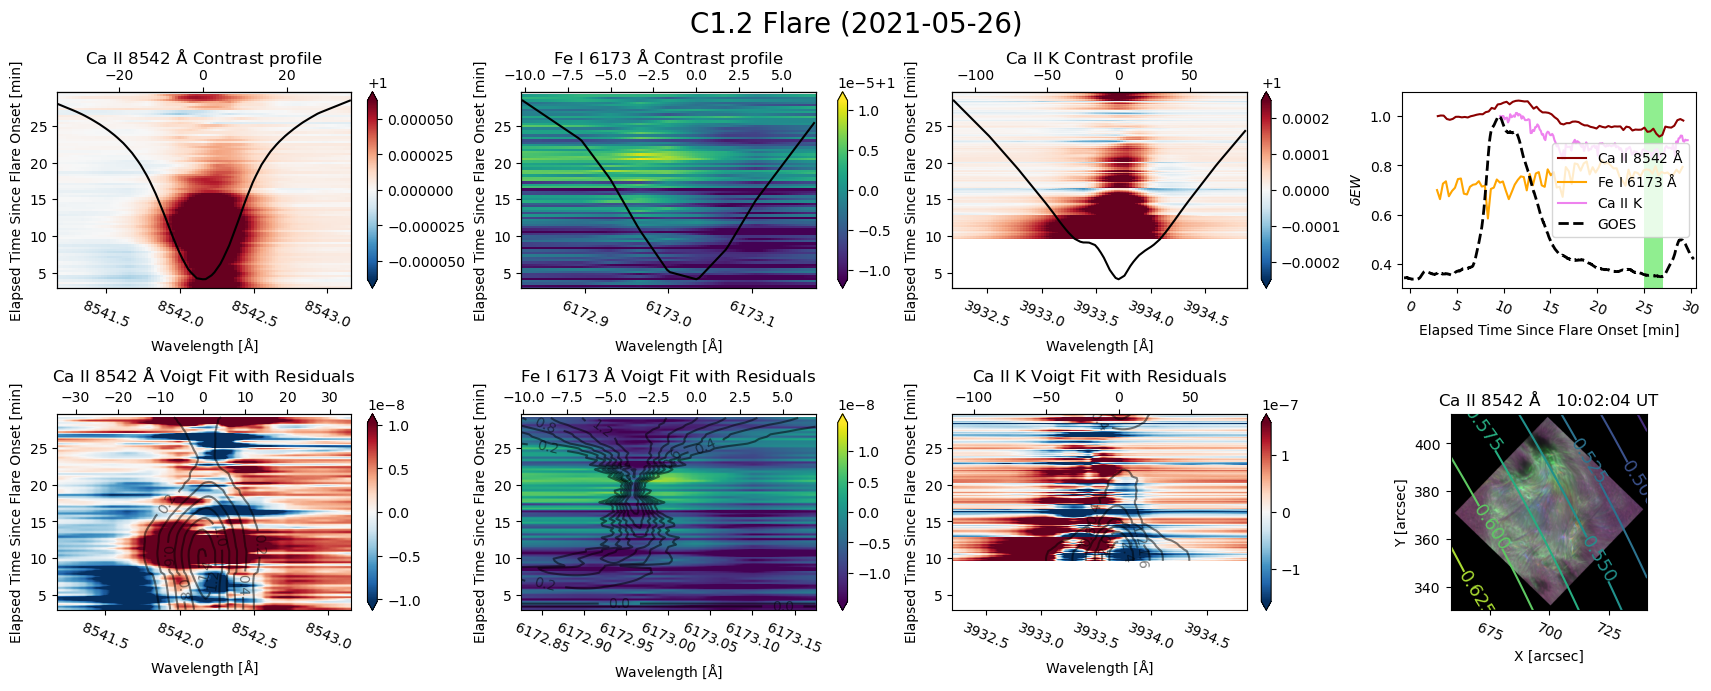

In [11]:
reload(un)
reload(un2)
# lines
lines = ["CaIR21", "Fe21", "CaK21"] 
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "C1.2 Flare (2021-05-26)"

# make figure
t = 0.85
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot
offset_DEW = [0,1.7,0]
scalefactor = 1/1
Xtra_N = 8
norm = {"CaIR":9, "CaK(2)":28, "Fe6173":9, "CaK":0, "Ha":9, "Hbeta":62, "He":29 }
cocotime = 83//2
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line='CaIR21')
offset_DEW = np.zeros(7)
Xtra_N=1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2016 flare

<string>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<string>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3937751807.py:29: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3937751807.py:29: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR16
Centerd contrast plot vmin=0.9999547557363835, vmax=1.0000452442636165.
plotting element CaIR name: CaIR16
vmax = 5.13911263595904e-08, vmin = -5.13911263595904e-08
scaled flare: Line Ha16
Centerd contrast plot vmin=0.9998985040791433, vmax=1.0001014959208567.
plotting element Ha name: Ha16
vmax = 1.3076030728682062e-07, vmin = -1.3076030728682062e-07
The normalizatie segment is [55 60]
line center at 8542.16338201091
CaIR16 Bounds: 1.0 0
line center at 6562.855047599012
Ha16 Bounds: 1.0 -0.5075064320890854
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_C8.4.npz' with keys: time, xrs_long
['2016-05-14T00:00:00.000000000' '2016-05-14T00:00:00.000000000'
 '2016-05-14T00:00:01.648000000' ... '2016-05-14T23:59:57.865000000'
 '2016-05-14T23:59:59.825000000' '2016-05-14T23:59:59.911000000']
[3.1513639e-07 3.0708657e-07 3.0620635e-07 ... 4.9218079e-07 5.2668753e-07
 5.0312048e-07]
GOES: 1.0 0.02103425851531478 0.8632619159472442
		Used rotation is -17.535

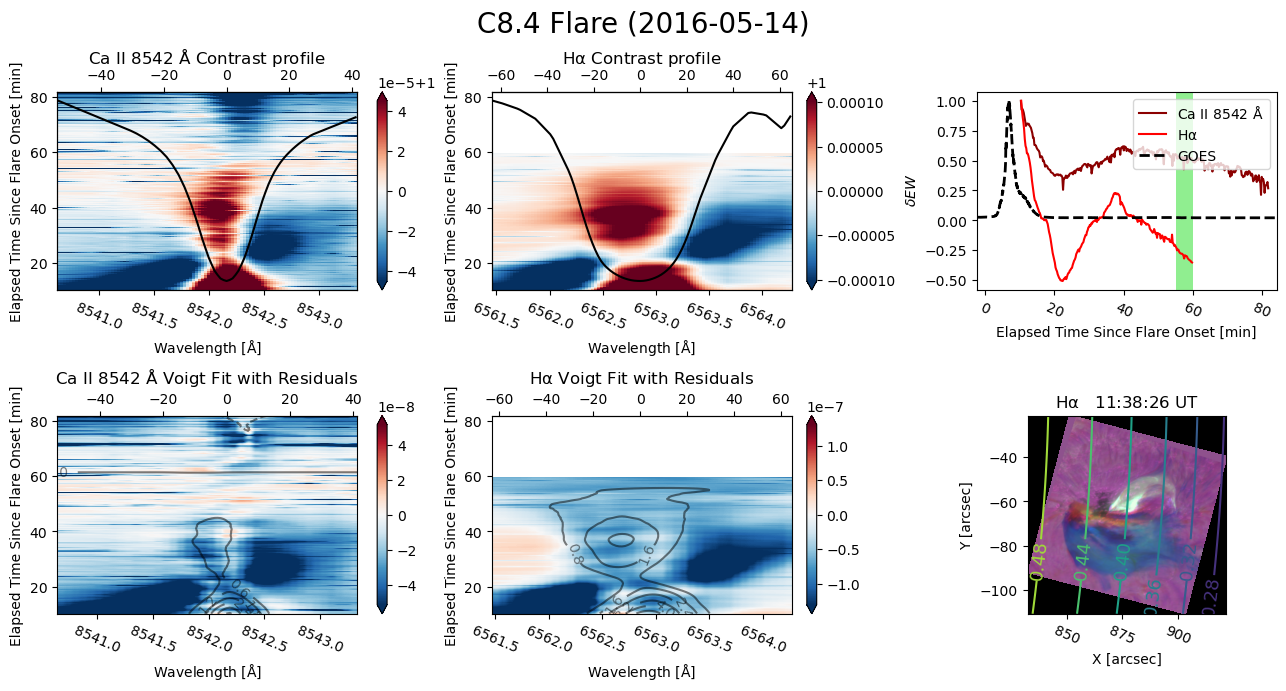

In [12]:
reload(un)
reload(un2)
# lines
lines = ["CaIR16", "Ha16"]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "C8.4 Flare (2016-05-14)"

# make figure
t = 0.85
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot

scalefactor = 1/1
scales_DEW = [1, 1]
norm = {"CaIR":3, "CaK(2)":28, "Fe6173":99, "CaK":0, "Ha":0, "Hbeta":62, "He":29 }
cocotime = 0
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Ha16")
scales_DEW = np.ones(7)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2014 flare

<string>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<string>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\{'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1633298342.py:28: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1633298342.py:28: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha14
Centerd contrast plot vmin=0.9996037688470867, vmax=1.0003962311529133.
plotting element Ha name: Ha14
vmax = 4.5918819442360046e-08, vmin = -4.5918819442360046e-08
The normalizatie segment is [4.5 6. ]
line center at 6562.759800031761
Ha14 Bounds: 2.0075035421255802 -1.0151757704603026
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_X1.5.npz' with keys: time, xrs_long
['2014-06-10T00:00:00.000000000' '2014-06-10T00:00:01.355000000'
 '2014-06-10T00:00:03.405000000' ... '2014-06-10T23:59:55.715000000'
 '2014-06-10T23:59:57.761000000' '2014-06-10T23:59:59.811000000']
[1.2685755e-06 1.2484597e-06 1.2484597e-06 ... 2.9571233e-06 2.9533596e-06
 2.9533596e-06]
GOES: 2.0 0.03578361355257073 1.9991000207845087


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2379255630.py:431: RuntimeWarning: invalid value encountered in arcsin
  return np.cos(np.arcsin(rad_dist))



    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/X1.5_Flare_(2014-06-10).pdf}
        \caption{
    \textbf{The full X1.5 Flare (2014-06-10):} NESSI calculated full disk profiles 
    for $\sim 75$\% flare capture. \textbf{Upper left:} 
    Contrastprofiles to the quiet sun for the lines \Halpha.
    \textbf{Lower left:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. 
    \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line overlayed with contour 
    lines of the $\mu$-value. 
    }
        \label{fig:2014}
    \end{figure*}
    


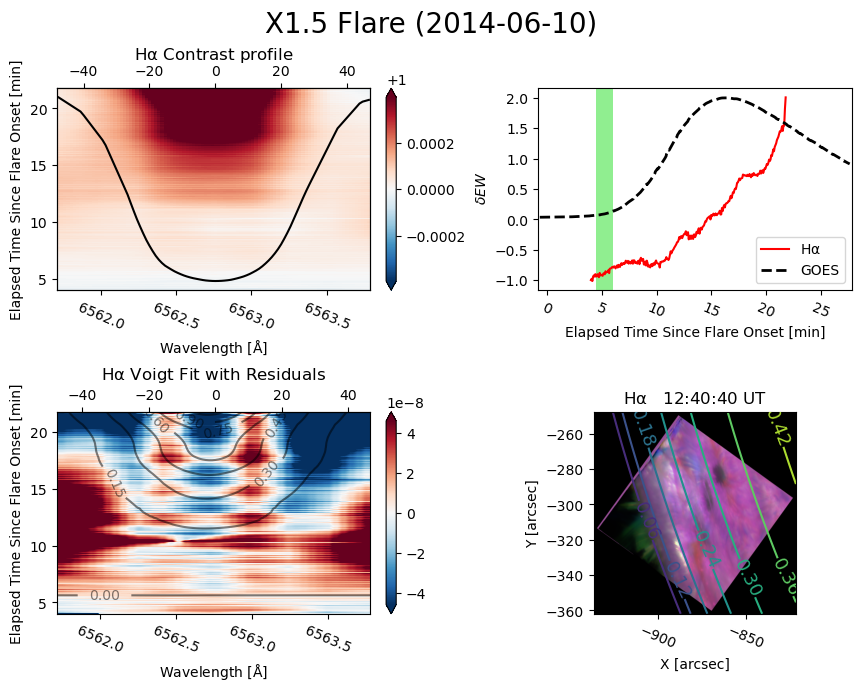

In [13]:
reload(un)
reload(un2)
# lines
lines = ["Ha14"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "X1.5 Flare (2014-06-10)"

# make figure
t = 0.85
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot
Xtra_N = 5
scalefactor = 1/0.75
Scale_GOES = 2
norm = {"CaIR":9, "CaK(2)":28, "Fe6173":99, "CaK":0, "Ha":9, "Hbeta":62, "He":29 }
cocotime = 10
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime)
Xtra_N = 1
Scale_GOES = 1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# 2015b flare

<string>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<string>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\{'
<>:29: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2617664003.py:29: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2617664003.py:29: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line He15b
Centerd contrast plot vmin=0.9999941685207587, vmax=1.0000058314792413.
plotting element He name: He15b
vmax = 3.5490428520391466e-08, vmin = -3.5490428520391466e-08
The normalizatie segment is [ 5 10]
line center at 5877.254
He15b Bounds: 0 -1.0
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_C3.6.npz' with keys: time, xrs_long
['2015-05-05T00:00:00.000000000' '2015-05-05T00:00:00.000000000'
 '2015-05-05T00:00:00.191000000' ... '2015-05-05T23:59:56.631000000'
 '2015-05-05T23:59:58.145000000' '2015-05-05T23:59:58.681000000']
[1.4444608e-06 1.4411211e-06 1.4702556e-06 ... 2.2669014e-06 2.2349270e-06
 2.2631380e-06]
GOES: 1.0 0.6536170988635674 0.9990593604510963
		Used rotation is -18.933072030211868.

    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/C3.6_Flare_(2015-05-05).pdf}
        \caption{
    \textbf{The full C3.6 Flare (2015-05-05):} NESSI calculated full disk profiles 
    for $\sim 95$

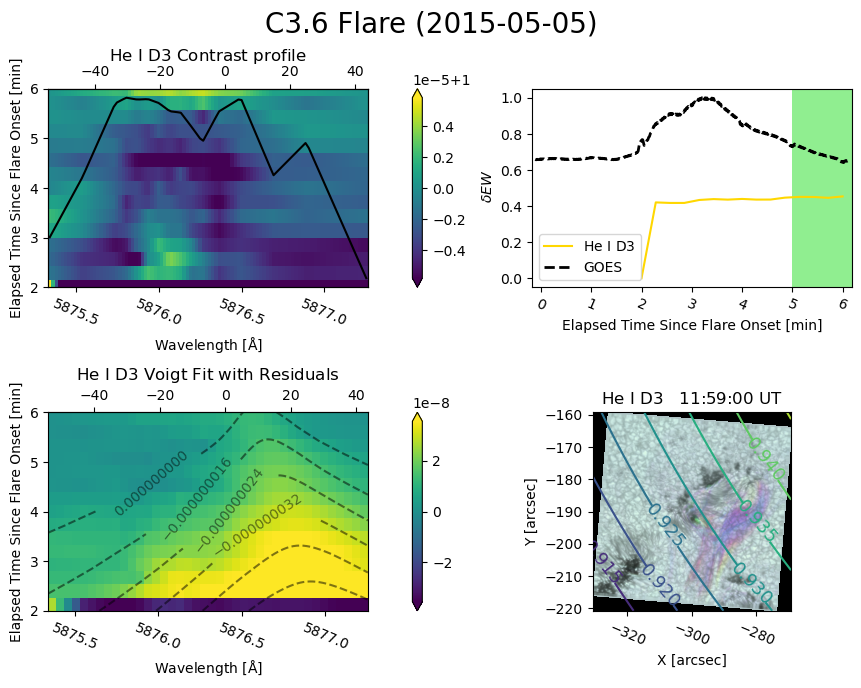

In [14]:
reload(un)
reload(un2)
# lines
lines = ["He15b"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "C3.6 Flare (2015-05-05)"

# make figure
t = 0.85
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot
Xtra_N = 10
scalefactor = 1/0.95
offset_DEW = [1]
norm = {"CaIR":9, "CaK(2)":28, "Fe6173":99, "CaK":0, "Ha":9, "Hbeta":62, "He":14 }
cocotime = 15//2
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime)
Xtra_N = 1
offset_DEW = np.zeros(7)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# C2.0

<string>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<string>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1261655486.py:35: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1261655486.py:35: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR19
Centerd contrast plot vmin=0.9998922842094728, vmax=1.0001077157905272.
plotting element CaIR name: CaIR19
the special flare
vmax = 1.8831396518919355e-08, vmin = -1.8831396518919355e-08
scaled flare: Line Fe6173_2019
Centerd contrast plot vmin=0.9999828989270503, vmax=1.0000171010729497.
plotting element Fe6173 name: Fe6173_2019
the special flare
vmax = 1.2832660961729472e-08, vmin = -1.2832660961729472e-08
scaled flare: Line CaK19
Centerd contrast plot vmin=0.9998013937081227, vmax=1.0001986062918773.
plotting element CaK name: CaK19
the special flare
vmax = 5.047612954703267e-08, vmin = -5.047612954703267e-08
The normalizatie segment is [-10  -5]
line center at 8542.06276117715
CaIR19 Bounds: 1.5479794902664448 0
line center at 6173.300797611692
Fe6173_2019 Bounds: 1.5479794902664448 -1.109122274741847
line center at 3933.677332163953
CaK19 Bounds: 1.5479794902664448 -1.109122274741847
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_C2.0.npz' wit

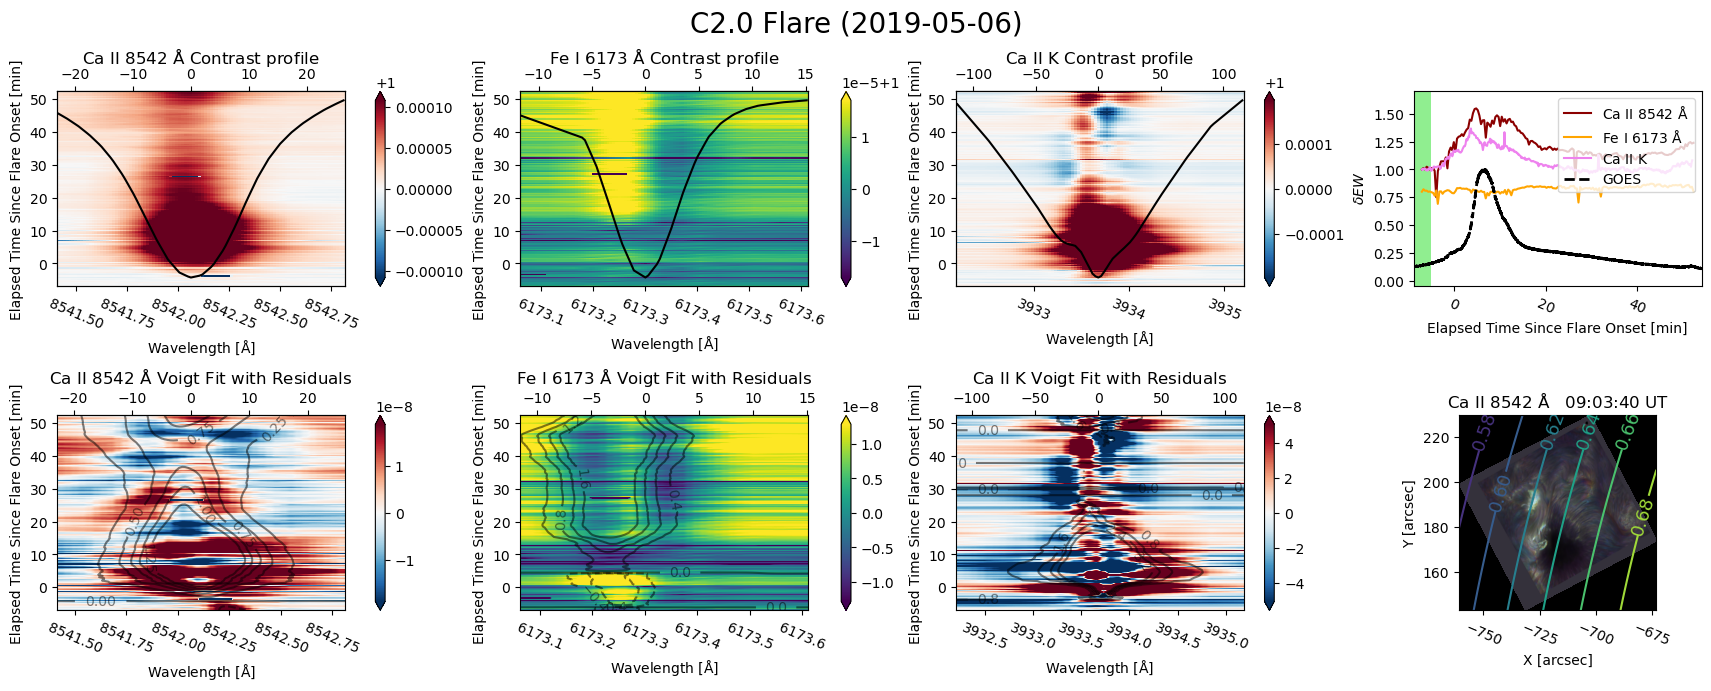

In [15]:
reload(un)
reload(un2)
# lines
lines = [ "CaIR19", "Fe6173_2019", "CaK19"]
qs_sub = [False, False, False]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "C2.0 Flare (2019-05-06)"

# make figure
t = 0.85 
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
# plt.xticks(rotation=70)
plt.tick_params(axis='x', which='major', rotation=-70)  
fig.suptitle(title, fontsize=20)



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = 1/1
Scale_GOES = 1
offset_DEW = [ 0, 1.8, 0]
norm = {"CaIR":0, "CaK(2)":0, "Fe6173":9, "CaK":0, "Ha":9, "Hbeta":62, "He":0 }
cocotime = 170//2
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="CaIR19")
ax[0,-1].set_ylim(-0.05, 1.7)
offset_DEW = np.zeros(7)
Scale_GOES = 1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


# M1.1 Flare 

<string>:32: SyntaxWarning: invalid escape sequence '\{'
<>:32: SyntaxWarning: invalid escape sequence '\{'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<string>:32: SyntaxWarning: invalid escape sequence '\{'
<>:32: SyntaxWarning: invalid escape sequence '\{'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3839824752.py:32: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3839824752.py:32: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


dict_keys(['area_theta_CaIR14a', 'FOV_CaIR14a', 'quiet_sun_CaIR14a', 'nessi_CaIR14a', 'True_nessi_CaIR14a', 'TIME_CaIR14a', 'area_theta_Ha14a', 'FOV_Ha14a', 'quiet_sun_Ha14a', 'nessi_Ha14a', 'True_nessi_Ha14a', 'TIME_Ha14a'])
scaled flare: Line CaIR14a
Centerd contrast plot vmin=0.9998177267198554, vmax=1.0001822732801446.
plotting element CaIR name: CaIR14a
vmax = 1.4443915915008186e-07, vmin = -1.4443915915008186e-07
scaled flare: Line Ha14a
Centerd contrast plot vmin=0.9998078368463865, vmax=1.0001921631536135.
plotting element Ha name: Ha14a
vmax = 9.65114793921382e-08, vmin = -9.65114793921382e-08
The normalizatie segment is [-90 -75]
line center at 8542.057258712677
CaIR14a Bounds: 2.012360447052402 0
line center at 6562.788182743621
Ha14a Bounds: 2.388039894394461 0
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_M1.1.npz' with keys: time, xrs_long
['2014-09-06T00:00:00.000000000' '2014-09-06T00:00:00.000000000'
 '2014-09-06T00:00:00.838000000' ... '2014-09-06T23:59:5

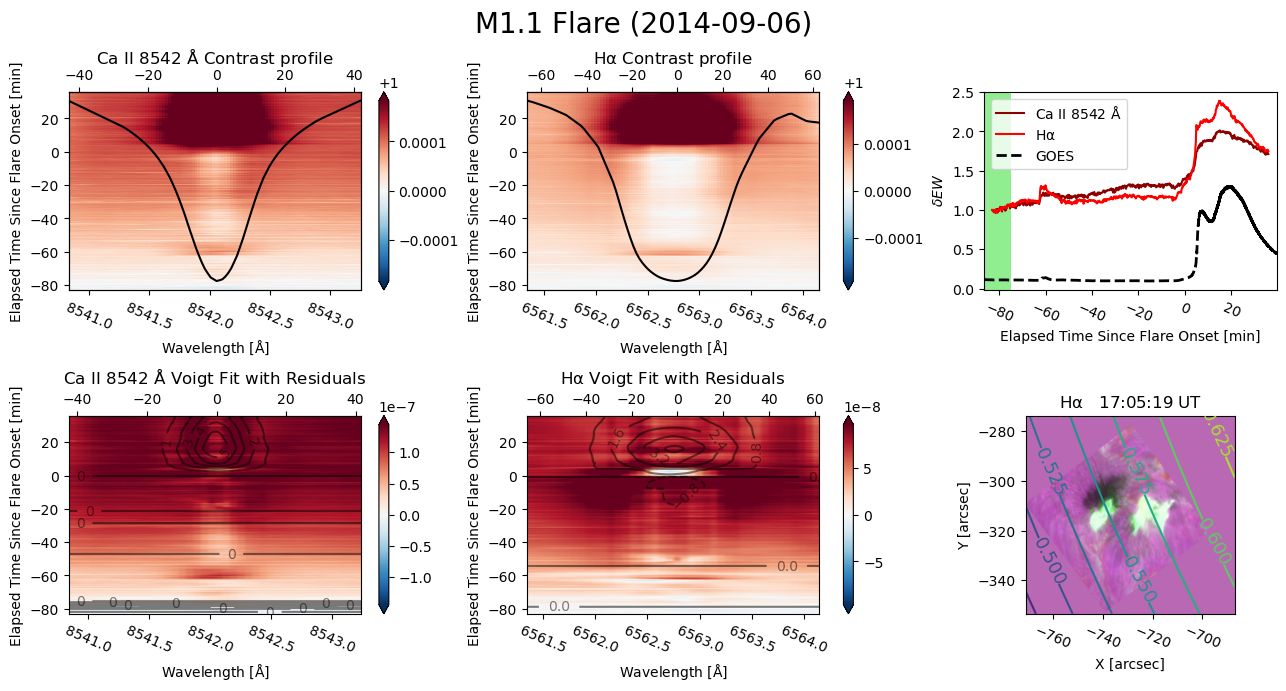

In [16]:
reload(un)
reload(un2)
lines = [ "CaIR14a", "Ha14a"]

data = un.load_for_further_analysis(lines, full_path = "E:/solar flares/data/2014-09-06/")
print(data.keys())


# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "M1.1 Flare (2014-09-06)"

# make figure
t = 0.85 
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)



# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = 1/1
Scale_GOES = 1.3
norm = {"CaIR":9, "CaK(2)":0, "Fe6173":9, "CaK":0, "Ha":9, "Hbeta":62, "He":0 }
cocotime = 510
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Ha14a")
Scale_GOES = 1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# C1.7 Flare

<string>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<string>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3434563671.py:35: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3434563671.py:35: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


dict_keys(['area_theta_CaIR17a', 'FOV_CaIR17a', 'quiet_sun_CaIR17a', 'nessi_CaIR17a', 'True_nessi_CaIR17a', 'TIME_CaIR17a', 'area_theta_Hbeta17a', 'FOV_Hbeta17a', 'quiet_sun_Hbeta17a', 'nessi_Hbeta17a', 'True_nessi_Hbeta17a', 'TIME_Hbeta17a'])
scaled flare: Line CaIR17a
Centerd contrast plot vmin=0.9994611752909974, vmax=1.0005388247090026.
plotting element CaIR name: CaIR17a
vmax = 1.745380089967374e-07, vmin = -1.745380089967374e-07
scaled flare: Line Hbeta17a
Centerd contrast plot vmin=0.9981832775698181, vmax=1.001816722430182.
plotting element Hbeta name: Hbeta17a
vmax = 1.1271672666228875e-07, vmin = -1.1271672666228875e-07
The normalizatie segment is [120 135]
line center at 8542.151008812849
CaIR17a Bounds: 0 -1.575924441035431
line center at 4861.332456594738
Hbeta17a Bounds: 0 -1.575924441035431
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_X8.2.npz' with keys: time, xrs_long
['2017-09-10T00:00:00.000000000' '2017-09-10T00:00:00.000000000'
 '2017-09-10T00:00:00.0

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2379255630.py:431: RuntimeWarning: invalid value encountered in arcsin
  return np.cos(np.arcsin(rad_dist))



    \begin{figure*}
        \centering
        \includegraphics[width=0.75\linewidth]{Full_analysis_plots/X8.2_Flare_(2017-09-10).pdf}
        \caption{
    \textbf{The full X8.2 Flare (2017-09-10):} NESSI calculated full disk profiles 
    for $\sim 50$\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \CaIR and \Hbeta.
    \textbf{Lower left 2:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. 
    \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. 
    \textbf{Lower right:} A cocoplot of the FOV in the \CaIR line overlayed with contour 
    lines of the $\mu$-value. 
    }
        \label{fig:2017}
    \end{figure*}
    


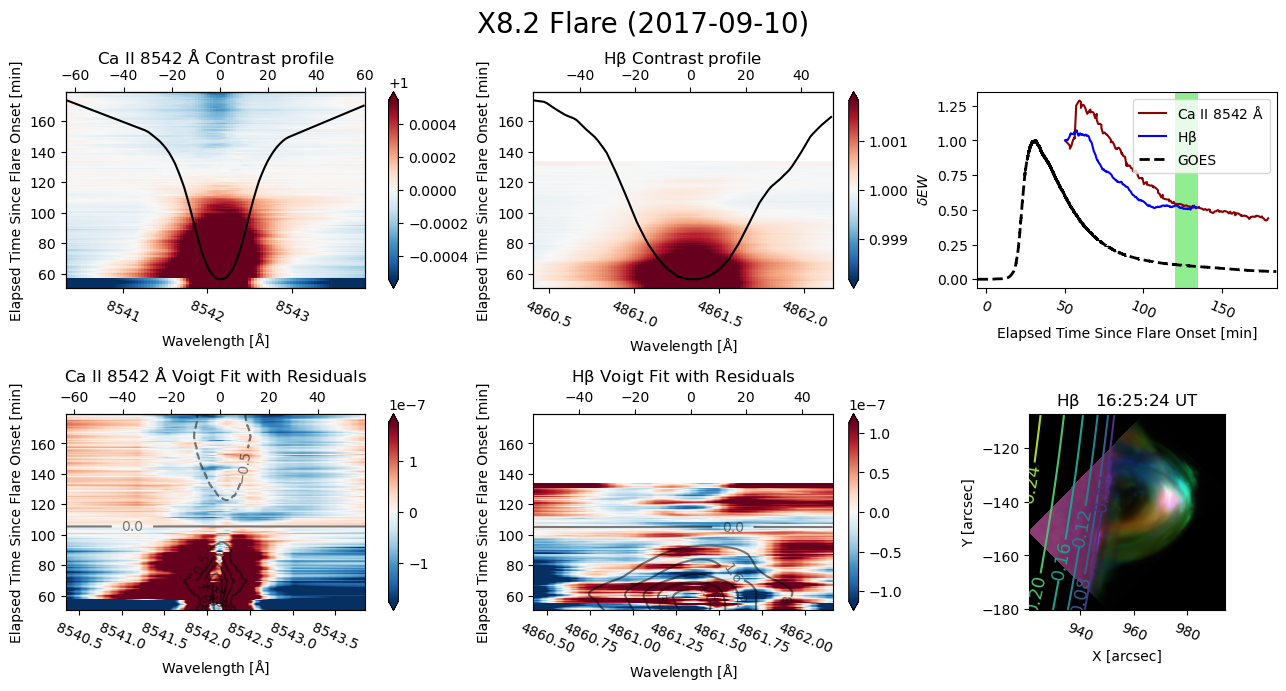

In [17]:
reload(un)
reload(un2)
lines = ["CaIR17a", "Hbeta17a"] #], "CaK17a"]

data = un.load_for_further_analysis(lines, full_path = "E:/solar flares/data/2017-09-10/")
print(data.keys())
# un2.disgard_cont_point("CaK17a", data)
# un2.split_data_in_two_lines("CaK17a", data, 3950, lines)




# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "X8.2 Flare (2017-09-10)"

# make figure
t = 0.85 
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(1/0.5,1)
offset_DEW = [2,2]
norm = {"CaIR":3, "CaK(2)":0, "Fe6173":9, "CaK":0, "Ha":9, "Hbeta":9, "He":0 }
cocotime = 0
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Hbeta17a")
offset_DEW = np.zeros(7)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# Analysis of X9.3 flare

<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\101680665.py:25: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\101680665.py:25: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaII17
Centerd contrast plot vmin=0.9982889910632919, vmax=1.001711008936708.
plotting element CaIR name: CaII17
vmax = 3.860181825073085e-07, vmin = -3.860181825073085e-07
scaled flare: Line Ha17
Centerd contrast plot vmin=0.9985575448466915, vmax=1.0014424551533085.
plotting element Ha name: Ha17
vmax = 3.4858737876067544e-07, vmin = -3.4858737876067544e-07
scaled flare: Line CaK17
Centerd contrast plot vmin=0.990870707171627, vmax=1.009129292828373.
plotting element CaK name: CaK17
vmax = 4.733764499702099e-07, vmin = -4.733764499702099e-07
The normalizatie segment is [43 50]
line center at 8542.169446446858
CaII17 Bounds: 1.7604750779509108 0
line center at 6562.833941407014
Ha17 Bounds: 1.7604750779509108 0
line center at 3933.693303030303
CaK17 Bounds: 1.7604750779509108 0
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_X9.3.npz' with keys: time, xrs_long
['2017-09-06T00:00:00.000000000' '2017-09-06T00:00:00.000000000'
 '2017-09-06T00:00:00.000000000

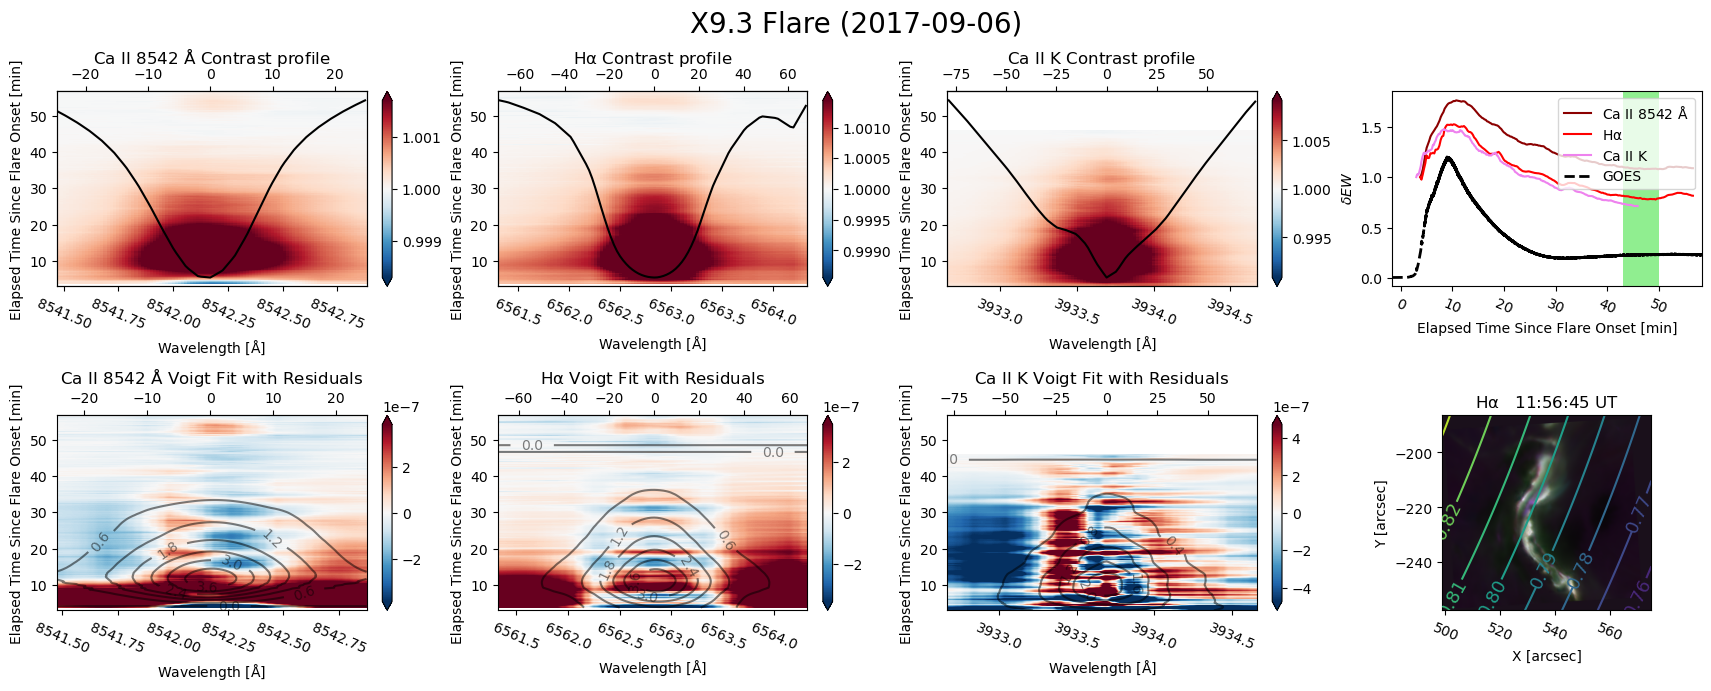

In [18]:

# lines
lines = ["CaII17", "Ha17", "CaK17" ]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "X9.3 Flare (2017-09-06)"

# make figure
t = 0.85 
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(5/2,1)
Scale_GOES = 1.2
norm = {"CaIR":3, "CaK(2)":3, "Fe6173":9, "CaK":3, "Ha":9, "Hbeta":62, "He":0 }
cocotime = 0
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Ha17")
Scale_GOES = 1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

**Figure Description**: \textbf{The full Analysis of the X9.3 flare:} NESSI calculated full disk profiles for ~40% flare capture. \textbf{Upper left 3:} Contrastprofiles to the quiet sun for the lines \Halpha, \CaK and \CaIR. \textbf{Lower left 3:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line overlayed with contour lines of the $\mu$-value. 

Full analysis of the X9.3 flare. For the Available lines \Halpha, \CaIR and \CaK the three discussed methods of analysis are applied: NESSI generate virtual full disc spectum shown in the upper row, voigt fit and residue




**In text notice**: For the X9.3 the flare analysis we have preformed is plotted in \autoref{}. 
Here the full disk profiles are calculated by NESSI for the 3 availble lines \Halpha, \CaK and \CaIR and shown in the upper tree contrast profiles. The FOV of the SST captured 
approximately 40% of the flare area so we scaled by 
The difference to quiet spectrum normalized is displayed so a 0.15% increase in \Halpha, 1.5% increase in \CaK and 0.4% increase in \CaIR is found mostely in the line center.
It appears that the width of the broadening is comparable to the line width. We fitted this intensity increase with a voigt profile and in the lower 3 maps the shape of the 
voigt profiles is shown with contour lines.  By the voigt countour lines the peak of and the decrease after the flare even more clear than in the displays above.  The residues of this fitting are plotted in the same plots with a color map, which showing the intensity with pure thermal increase subtracted. In this way the telluric in \Halpha is a prominent feature and a slightly increasing absorption in the left wing after the flare can be observed as wel (\textbf{What does this mean?}).
In \CaK we observe a rather strong change in absorption and emission in the line center, which might be caused by the line shape of \CaK. Other features are an increasing absorption in the left wing analogous to \Halpha and the slowly decaying emmission in the right wing, which might be a sign of coronal rain?????? In \CaIR the horizontal oddity of voigt fits and residues is not caused by misfitting but is truely caused by the flare. Although the fit is at the start of the flare is somewhat more uncertain the shape of the voigt profiles are quiet consistent in time and thus the rather strong increase in the right wing and left center are by the nature of the flare. The minor features from \CaK are here observed as well: an increasing absorption in the left wing and the slowly decaying emmission in the right wing. For the differential equivalent width (DEW) are plotted in the rigth upper corner and are a measure of the increase of intensity as shown before by \citet{Otsu}. The 3 lines beheave similar during the evolution in their respective DEW where we see a peak around 5 minutes followed by a slowing decay. 

In [19]:
# saving this data for collaboration
def saving_Full_line_ana(names_of_lines_list, scalefactor, name_of_flare="X9.3"):
    data = get_data(names_of_lines_list)
    for name in names_of_lines_list:
        wav, DFD , time, line, std = un2.contrast_FD_data(name,data, quiet_sun_subtraction=False, area_factor=area_factor*scalefactor, normal=True, add_noise=False)
        print(np.shape(wav))
        params, voigt, res = load_voigt_data(name, wav)
        c = area_factor*scalefactor
        
        filename = f"data/data_{name}_{name_of_flare}_voigt_residue_analysis.npz"

        np.savez(filename, time, wav, DFD, std, c*params, c*res)
        
        

# lines
lines = ["Ha17", "CaK17", "CaII17"]
flare_name = "X9.3"
scalefactor = round(5/2,1)

# saving_Full_line_ana(lines, scalefactor, name_of_flare=flare_name)

data_structure = """
Discription of "data_{name}_{name_of_flare}_voigtresidue_analysis.npz" file:
arr_0:  time        time in minutes from the start of the flare (as in solar monitor or tabel below.)
arr_1:  wav         wavelength positions in angstrom
arr_2:  DFD         Difference intencity for Full Disk synthesized spectrum compared to quiet full disk spectrum (time x wav- array)
arr_3:  std         Standard deviation in spectral position for DFD (wav - array)
arr_4:  params      voig fit parameters in time. the 4 parameters are amplitude, center, sigma, gamma. See below for implementation (time x 4 -array)
arr_5:  res         Residues to the voigt fit in time. (time x wav - array)


def gaussian(x, amp_g, cen_g, sigma_g):
    # Gaussian function.
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    # Lorentzian function.
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, param, offset=0):
    # Voigt profile: approximation by combining Gaussian and Lorentzian.
    amp_v, cen_v, sigma_v, gamma_v = param
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset
            
            
\\begin{table*}[ht]
    \centering
    \caption{Flare Information}
    \label{tab:flare_info} 
    \\begin{tabular}{llllllllll}
        \\toprule
        Year & NOAA & Class & Start/Stop/Peak & SST Start/Stop & Overlap & (X, Y) & $\mu$ & Lines & Cad [s] \\
        \midrule
        2017-09-06 &  12673 & X9.3 &11:53/12:10/12:01 &11:56/12:52 & appr 40\% & (513'', -216'') & 0.815 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\ & & & & & & & & \CaK & 6.6 \\
        2017-09-06 & 12673 & X2.2 & 8:57/9:17/09:09 &09:04/09:54 & appr 60\% & (542'', -208'') & 0.803 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0 \\ & & & & & & & & \CaK & 6.6 \\ 
        2015-06-24 &  12371 & C5.6&	15:12/15:40/15:29 &-/- &  & (496'', 175'') &  & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\
        2011-08-06 &  	11267 & C4.1 &08:37/08:51/08:47 &-/- & appr 40\% & (S17 E12) & 0.815 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\ & & & & & & & & \CaK & 6.6 \\
        2019-05-06 &12740 & C2.0  &08:41/08:51/08:47 &08:34/09:33&&(-716.9'', 186.2'')& 0.638 & \Fe6173 & 20.9 \\ & & & & & & & & \CaIR  & 20.9\\ & & & & & & & & \CaK & 7.8 \\ 
        2013-06-30 & 11778 & C1.5 &09:11/09:27/09:18 &09:16/10:17&100\%&(323.4'', -287.9'')& 0.892 & \Halpha        & 7.3  \\
        \\bottomrule
    \end{tabular}
\end{table*}
"""



# Open the file in write mode ('w') and write content
with open("data/data_description.txt", "w") as file:
  file.write(data_structure)

print("Text file saved successfully!")



Text file saved successfully!


<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\3994107321.py:23: SyntaxWarning: invalid escape sequence '\c'
  data_structure = """


# X2.2 flare 

<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<string>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\{'
<>:25: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1183100042.py:25: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1183100042.py:25: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR17_9u
Centerd contrast plot vmin=0.9994002716410764, vmax=1.0005997283589236.
plotting element CaIR name: CaIR17_9u
vmax = 8.450536156389781e-08, vmin = -8.450536156389781e-08
scaled flare: Line Ha17_9u
Centerd contrast plot vmin=0.999305946512572, vmax=1.000694053487428.
plotting element Ha name: Ha17_9u
vmax = 1.0882587480958196e-07, vmin = -1.0882587480958196e-07
scaled flare: Line CaK17_9u
Centerd contrast plot vmin=0.9974708886875594, vmax=1.0025291113124406.
plotting element CaK name: CaK17_9u
vmax = 7.59588293569268e-07, vmin = -7.59588293569268e-07
The normalizatie segment is [50 61]
line center at 8542.163434974056
CaIR17_9u Bounds: 1.4601324152327542 0
line center at 6562.830792982248
Ha17_9u Bounds: 1.4601324152327542 0
line center at 3933.700554285045
CaK17_9u Bounds: 1.4601324152327542 0
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_X2.2.npz' with keys: time, xrs_long
['2017-09-06T00:00:00.000000000' '2017-09-06T00:00:00.000000000'
 '201

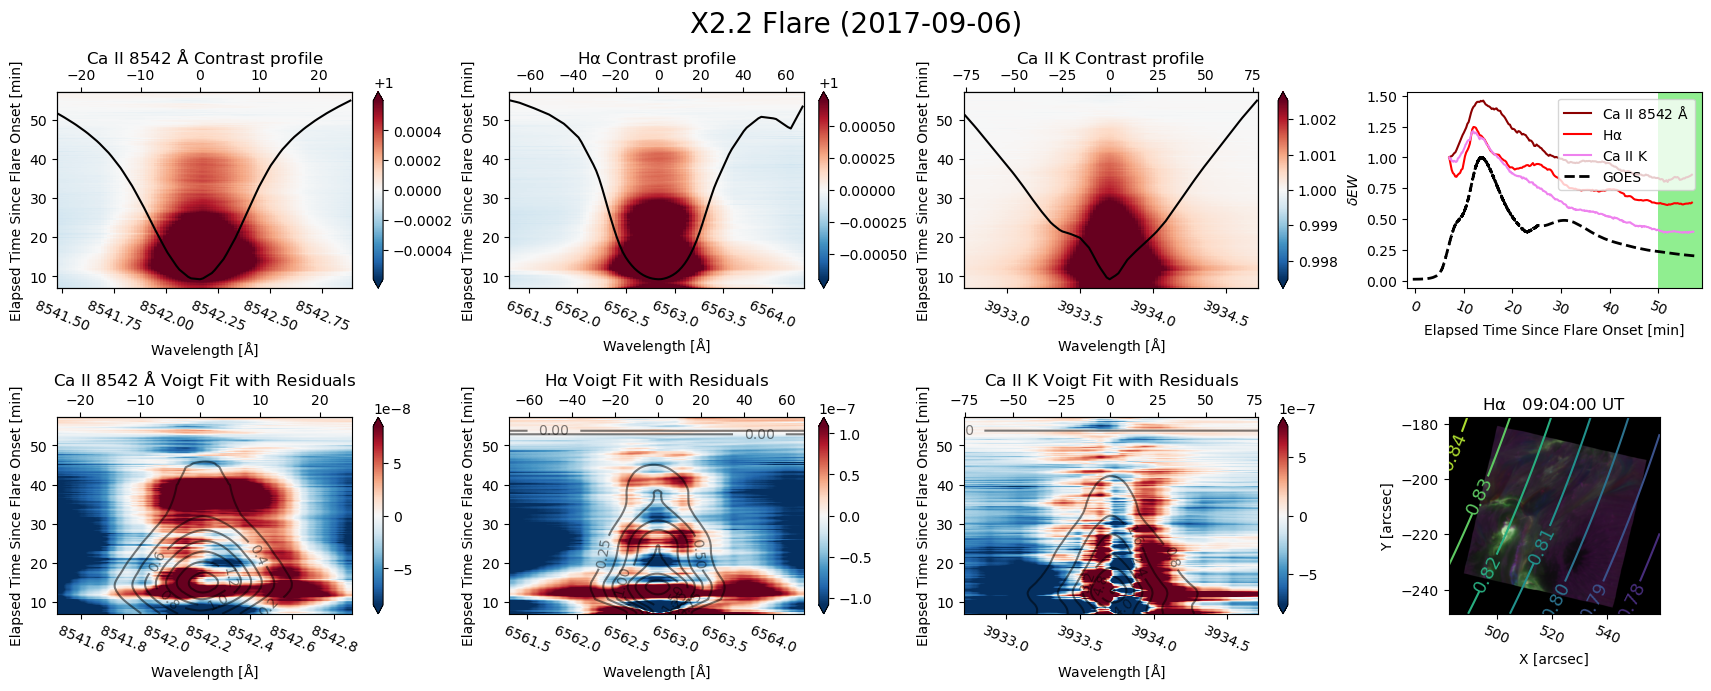

In [20]:
# lines
lines = ["CaIR17_9u", "Ha17_9u",  "CaK17_9u"]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "X2.2 Flare (2017-09-06)"

# make figure
t = 0.85 
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

Xtra_N=20
scalefactor = round(1/0.5,1)
norm = {"CaIR":0, "CaK(2)":0, "Fe6173":9, "CaK":0, "Ha":9, "Hbeta":62, "He":0 }
cocotime = 0
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Ha17_9u")
Xtra_N=1

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

**Figure Description**: \textbf{The full Analysis of the X2.2 flare:} NESSI calculated full disk profiles for ~60% flare capture. \textbf{Upper left:} Contrastprofiles to the quiet sun for the available line \Halpha. \textbf{Lower left:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 



**In text notice**: For the X2.2 the full flare analysis is plotted in \autoref{} in the same way as was done for the X9.3 flare, assuming $60\%$ capture of the flare. 
The only line \Halpha encountered an increase of $0.05\%$. The contrast plots show a smooth decay of the inensity with a bit of variance in the left wing. In general the wings are quiet strong in absorption. The DEW experience a sharp dip before the start of the flare. The maxima in the DEW are matched with the stronger emmission profiles in the contrast profiles in the top left plot and the contourlines underneath. The telluric is again present. 

# C1.5

<string>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<string>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\{'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1432024588.py:24: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\1432024588.py:24: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line Ha13
Centerd contrast plot vmin=0.999891083129947, vmax=1.000108916870053.
plotting element Ha name: Ha13
vmax = 5.236803578113624e-08, vmin = -5.236803578113624e-08
The normalizatie segment is [60 65]
line center at 6562.840271541155
Ha13 Bounds: 1.4696865927096296 -0.27731195631865185
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_C1.5.npz' with keys: time, xrs_long
['2013-06-30T00:00:00.000000000' '2013-06-30T00:00:00.148000000'
 '2013-06-30T00:00:02.195000000' ... '2013-06-30T23:59:54.421000000'
 '2013-06-30T23:59:56.468000000' '2013-06-30T23:59:58.515000000']
[3.3310801e-07 3.3284846e-07 3.3661203e-07 ... 6.3769812e-07 6.4146167e-07
 6.3769812e-07]
GOES: 1.0 0.2831760257759225 0.9986235711211836
		Used rotation is -8.140457029264264.

    \begin{figure*}
        \centering
        \includegraphics[width=0.5\linewidth]{Full_analysis_plots/C1.5_Flare_(2013-06-30).pdf}
        \caption{
    \textbf{The full C1.5 Flare (2013-06-30):} NESSI calculated ful

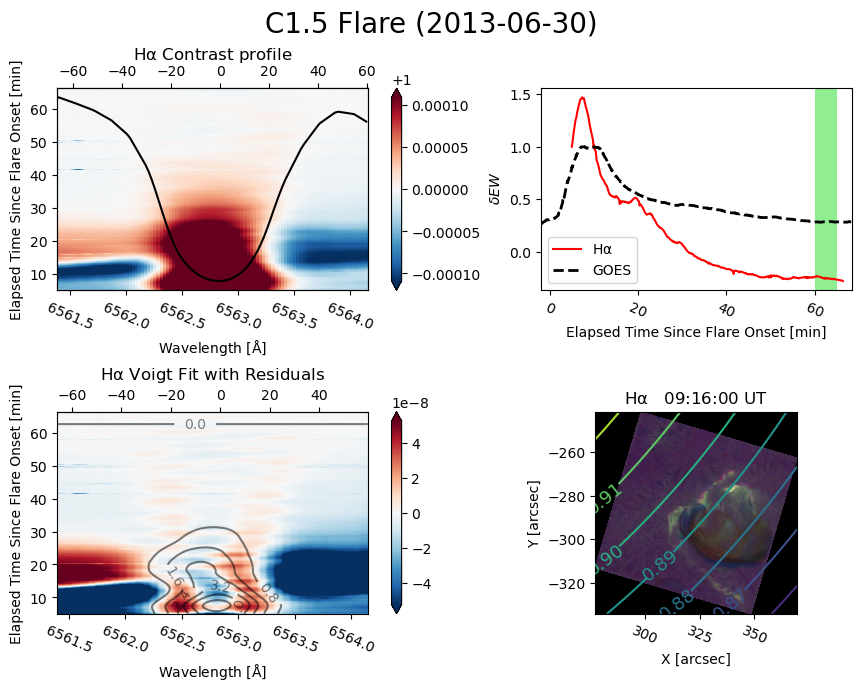

In [21]:
# lines
lines = ["Ha13"]

# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "C1.5 Flare (2013-06-30)"

# make figure
t = 0.85 
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)

# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = 1
norm = {"CaIR":0, "CaK(2)":0, "Fe6173":9, "CaK":0, "Ha":0, "Hbeta":62, "He":0 }
cocotime = 0
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

**Figure Description**: \textbf{The full the C1.5 flare:} NESSI calculated full disk profiles for assumed full flare capture. \textbf{Upper left:} Contrastprofiles to the quiet sun for the lines \Halpha. \textbf{Lower left:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 


**In text notice**: For the C1.5 full capture of the flare is assumed. The full flare analysis is plotted in \autoref{} in the same way as was done for the previous flares.
The only available line \Halpha encountered an increase of $0.0001\%$. The contrast plots show a smooth and assymetric wiggling decay of the inensity. at 20 minutes into the flare the assymmetry is the stronges which has its cause in the amount of material ejected and hanging in the frame . 


# M1.9 Flare

<string>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<string>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\{'
<>:26: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2218095243.py:26: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2218095243.py:26: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR15a
Centerd contrast plot vmin=0.9999319787214214, vmax=1.0000680212785786.
plotting element CaIR name: CaIR15a
vmax = 8.67530439448344e-08, vmin = -8.67530439448344e-08
scaled flare: Line Ha15a
Centerd contrast plot vmin=0.9997544985692124, vmax=1.0002455014307876.
plotting element Ha name: Ha15a
vmax = 2.987202629357961e-07, vmin = -2.987202629357961e-07
The normalizatie segment is [35 40]
line center at 8542.152159271123
CaIR15a Bounds: 1.1396663017706323 0
line center at 6562.839676714205
Ha15a Bounds: 1.1396663017706323 -1.0660949703591123
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_M1.9.npz' with keys: time, xrs_long
['2015-09-27T00:00:00.000000000' '2015-09-27T00:00:00.000000000'
 '2015-09-27T00:00:00.765000000' ... '2015-09-27T23:59:56.881000000'
 '2015-09-27T23:59:58.475000000' '2015-09-27T23:59:58.928000000']
[8.3902012e-07 8.3844878e-07 8.3805941e-07 ... 3.0304284e-06 2.8967356e-06
 3.0248873e-06]
GOES: 1.0 0.03243678248411688 0.99457032

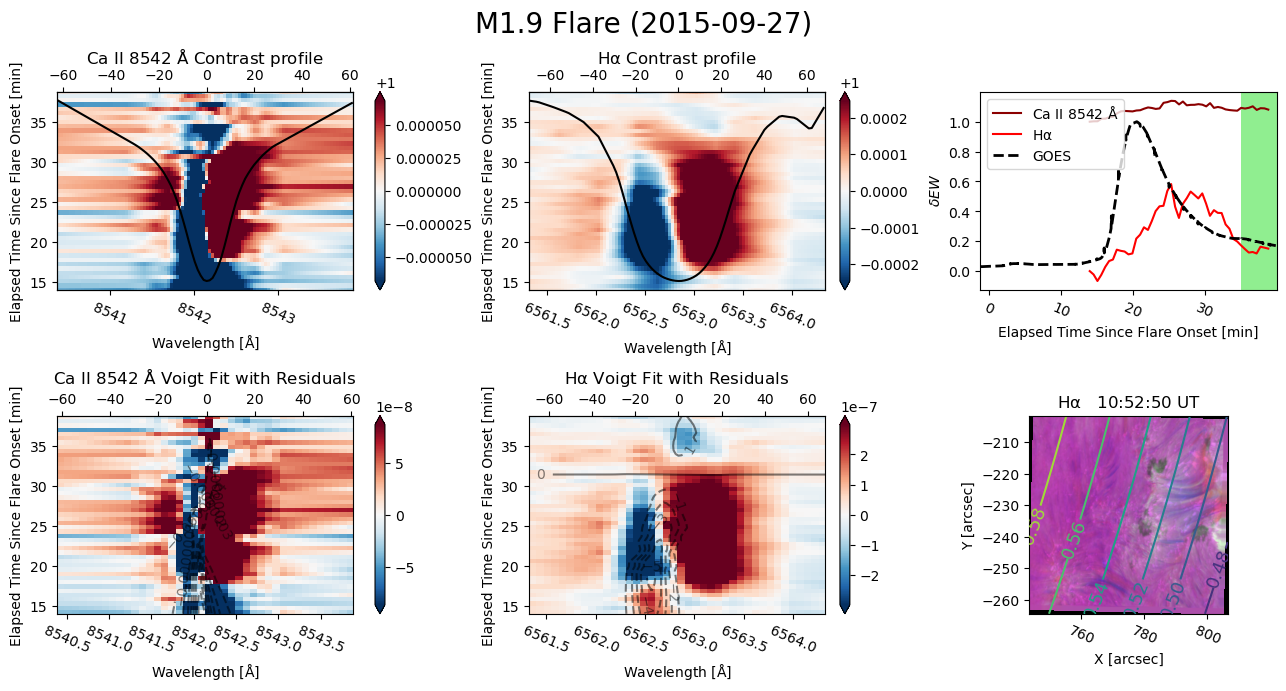

In [22]:
reload(un)
# lines
lines = ["CaIR15a", "Ha15a"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "M1.9 Flare (2015-09-27)"

# make figure
t = 0.85 
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(1/0.10,1)
offset_DEW = [0,1]
norm = {"CaIR":0, "CaK(2)":0, "Fe6173":9, "CaK":0, "Ha":3, "Hbeta":62, "He":0 }
cocotime = 35
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Ha15a")
offset_DEW = np.zeros(7)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

# C5.6 2015

<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<string>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\{'
<>:30: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2375351181.py:30: SyntaxWarning: invalid escape sequence '\{'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_15172\2375351181.py:30: SyntaxWarning: invalid escape sequence '\s'
  fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')


scaled flare: Line CaIR15
Centerd contrast plot vmin=0.9993470528867436, vmax=1.0006529471132564.
plotting element CaIR name: CaIR15
vmax = 3.5152727220430056e-07, vmin = -3.5152727220430056e-07
scaled flare: Line Ha15
Centerd contrast plot vmin=0.9996027528545817, vmax=1.0003972471454183.
plotting element Ha name: Ha15
vmax = 3.969069131623005e-07, vmin = -3.969069131623005e-07
The normalizatie segment is [70 80]
line center at 8542.150156986148
CaIR15 Bounds: 1.683046497651537 0
line center at 6562.827078667883
Ha15 Bounds: 1.683046497651537 -1.162962347687639
NpzFile 'E:\\solar flares\\data\\full_analysis\\data\\GOES_C5.6.npz' with keys: time, xrs_long
['2015-06-24T00:00:00.000000000' '2015-06-24T00:00:00.121000000'
 '2015-06-24T00:00:02.171000000' ... '2015-06-24T23:59:54.581000000'
 '2015-06-24T23:59:56.628000000' '2015-06-24T23:59:58.675000000']
[6.988615e-07 7.066482e-07 6.991211e-07 ... 7.028846e-07 7.028846e-07
 7.028846e-07]
GOES: 1.0 0.07119096399384685 0.9920563800219232

 

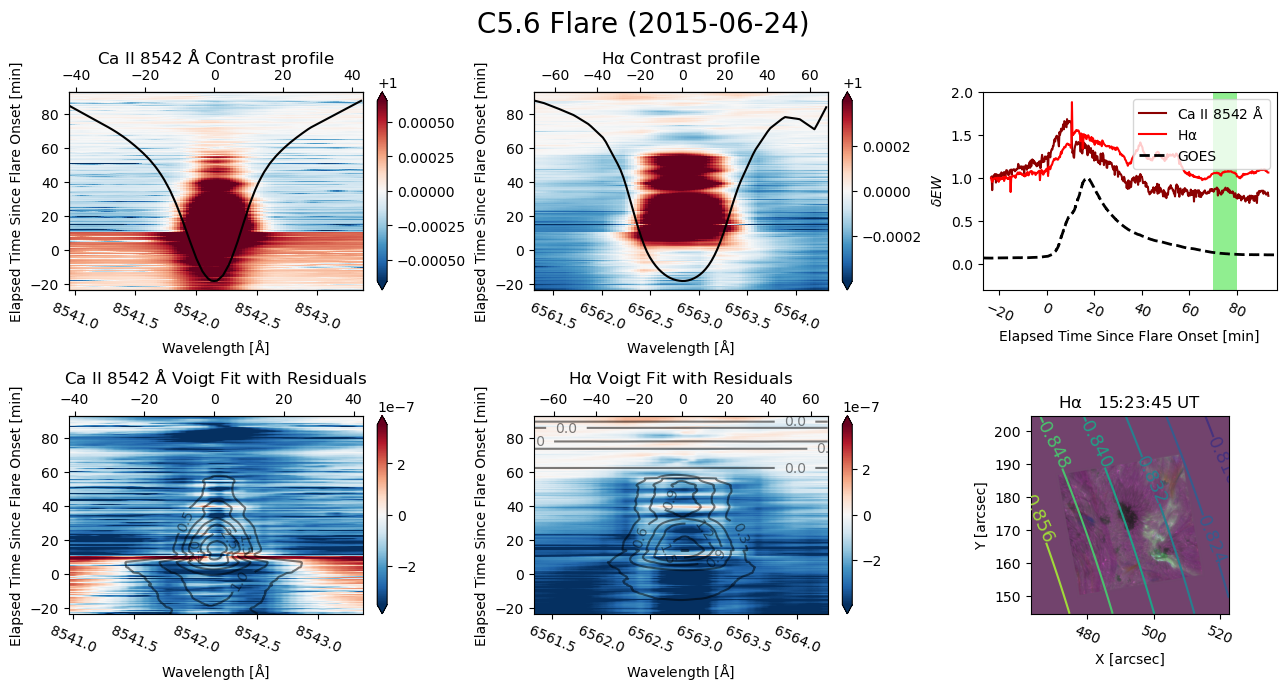

In [23]:
reload(un)
reload(un2)
# lines
lines = ["CaIR15", "Ha15"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "C5.6 Flare (2015-06-24)"

# make figure
t = 0.85 
fig, ax = plt.subplots(rows, cols, figsize=(5*t*cols,4*t*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = 1/0.1
Scale_GOES = 1
offset_DEW = [0,2]
norm = {"CaIR":0, "CaK(2)":0, "Fe6173":9, "CaK":0, "Ha":0, "Hbeta":62, "He":0 }
cocotime = 154
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title, T_norm=norm, cocotime=cocotime, name_of_show_line="Ha15")
offset_DEW = np.zeros(7)
Scale_GOES = 1
ax[0,-1].set_ylim(-.3, 2)

fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title.replace(" ", "_")}.pdf')

**Figure Description**: \textbf{The full Analysis of the C5.6 flare:} NESSI calculated full disk profiles for assumed full flare capture. \textbf{Upper left 2:} Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR. \textbf{Lower left 2:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 


**In text notice**: For the C5.6 full capture of the flare is assumed. The full flare analysis is plotted in \autoref{} in the same way as was done for the previous flares.
\Halpha encountered an increase of $8e-3\%$ and \CaK en increase of $0.015\%$. The contrast profiles show clearly the peak of the flare. In \CaIR a sharp transition is made around 12 minutes into the flare, approximately the peak of the flare. This change is visible over the entire band. Both in \Halpha and in \CaIR the flare is accompagned with a strong increase in the line center. In later times steadily appearing emmission in the wings can be seen. It seems as if the Telluric is also growing in strenght after the flare has happend. 
The voigt profile analysis around the discontinuity of \CaIR shows a similar jump. It seems as if the flare dies of instantly after this point in \CaIR. The DEW experience a discontinuity at the same time.